
# Variational Autoencoder (VAE) - Practical Session

## Section 0 - Recap: What is a VAE?

This section is a self-contained refresher on VAEs.  

### 0.1 The problem: generating high-dimensional data

We want a model that can **generate new high-dimensional data points** that look like the ones in our dataset.  
Formally, we would like to model a complex distribution over data $p(x)$, where $x$ is a point in a high-dimensional space $x \in \mathbb{R}^D$.

In general, $x$ could be an image, an audio clip, a text token sequence, a molecule, or some other structured object.

Directly modeling $p(x)$ is hard. Instead, we introduce a lower-dimensional **latent variable** $z$ which is supposed to capture abstract factors of variation (for example: style, stroke thickness, digit identity).

In a VAE, we define a generative model
$p(x, z) = p(z)\, p(x \mid z)$,
with a simple prior $p(z)$ (usually a standard normal) and a neural network decoder for $p(x \mid z)$.
Later, we will approximate the intractable posterior $p(z \mid x)$ with a neural network encoder.


### 0.2 Generative story of a VAE: prior and decoder

At the level of the probabilistic model, a VAE is just a latent-variable model.

We assume a simple prior over latent variables:
- Prior (latent space): $p(z) = \mathcal{N}(0, I)$

Given $z$, we decode back to data space with a neural network that defines a conditional distribution:
- Decoder or generative model: $p_\theta(x \mid z)$

For image data, common choices for $p_\theta(x \mid z)$ are:
- A factorized Bernoulli over pixels, which leads to a binary cross-entropy reconstruction term (often used for binarized MNIST).
- A Gaussian with fixed variance, which leads to a mean squared error reconstruction term.

Together, prior and decoder define the joint distribution
$$
p_\theta(x, z) = p(z)\, p_\theta(x \mid z).
$$

The generative procedure is:
1. Sample $z \sim p(z)$ (for example, a $2$-dimensional or $10$-dimensional standard Gaussian).
2. Compute the decoder output $p_\theta(x \mid z)$ using a neural network.
3. Either sample $x$ from that distribution or take its mean as a generated data point.

Intuitively, the prior shapes the global structure of the latent space, and the decoder learns how to turn latent codes into realistic data. If learning goes well, nearby points in latent space $z$ should decode to similar-looking samples.

---

### 0.3 Inference model: encoder and approximate posterior

For learning, we would like to use the posterior $p_\theta(z \mid x)$, but it is intractable for nonlinear neural decoders.

The VAE introduces an encoder network that defines a tractable **approximate posterior**:
- Encoder or inference model: $q_\phi(z \mid x)$

We parameterize $q_\phi(z \mid x)$ as a diagonal Gaussian whose parameters depend on $x$:
- Mean vector $\mu_\phi(x)$
- Log-variance vector $\log \sigma_\phi^2(x)$

so that
$$
q_\phi(z \mid x) = \mathcal{N}\big(z;\, \mu_\phi(x), \mathrm{diag}(\sigma_\phi^2(x))\big).
$$

Reasons for this parameterization:
- We use a diagonal covariance for simplicity and computational efficiency.
- We output $\log \sigma_\phi^2(x)$ rather than $\sigma_\phi(x)$ directly so that the network output is unconstrained, and we can recover positive variances via an exponential.

Later in the notebook, we will **sample** from $q_\phi(z \mid x)$ using the reparameterization trick:
$$
\epsilon \sim \mathcal{N}(0, I), \quad
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon,
$$
which allows gradients to flow through $z$ during backpropagation.

---

### 0.4 Training objective: ELBO and its interpretation

We would like to learn the parameters $(\theta, \phi)$ by maximizing the marginal log-likelihood $\log p_\theta(x)$ over the dataset. Directly optimizing $\log p_\theta(x)$ is intractable, so VAEs optimize a tractable lower bound instead.

For each data point $x$, the **Evidence Lower Bound (ELBO)** is
$$
\mathcal{L}(\theta, \phi; x)
=
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
-
\mathrm{KL}\big(q_\phi(z \mid x) \,\Vert\, p(z)\big),
$$
and it satisfies
$$
\log p_\theta(x)
=
\mathcal{L}(\theta, \phi; x)
+
\mathrm{KL}\big(q_\phi(z \mid x) \,\Vert\, p_\theta(z \mid x)\big)
\ge \mathcal{L}(\theta, \phi; x),
$$
because the KL divergence is always non-negative.

The ELBO decomposes into two terms:

- **Reconstruction term**
  $$
  \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
  $$
  This encourages the decoder to reconstruct $x$ accurately from samples of $z$.  
  In practice:
  - If $p_\theta(x \mid z)$ is Bernoulli per pixel, this becomes a sum of binary cross-entropies.
  - If $p_\theta(x \mid z)$ is Gaussian with fixed variance, this becomes a scaled mean squared error.

- **KL term**
  $$
  \mathrm{KL}\big(q_\phi(z \mid x) \,\Vert\, p(z)\big)
  $$
  This encourages the approximate posterior to stay close to the prior. It regularizes the encoder so that:
  - The latent codes do not drift too far from the prior.
  - The latent space stays smooth and well-organized, which is crucial for sampling and interpolation.

You can think of a VAE as a **regularized autoencoder**:
- Like a classic autoencoder, it wants good reconstructions.
- Unlike a classic autoencoder, it also wants a well-behaved latent distribution that roughly matches $p(z)$.

---

### 0.5 From ELBO to the loss we implement

In code, we usually **minimize** a loss rather than maximize the ELBO. For a single data point $x$ we define
$$
\mathcal{L}_{\text{VAE}}(x)
=
- \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
+
\mathrm{KL}\big(q_\phi(z \mid x) \,\Vert\, p(z)\big),
$$
which is just the negative ELBO:
- The first term becomes a reconstruction loss.
- The second term is the KL penalty.

Sometimes a weighting factor $\beta$ is inserted in front of the KL term (a $\beta$-VAE). We will start with $\beta = 1$ (the standard VAE objective) and optionally experiment with other values later.

In practice:
- The expectation over $q_\phi(z \mid x)$ is approximated with one or a few Monte Carlo samples using the reparameterization trick.
- The KL term between two Gaussians (diagonal covariance vs standard normal) has a closed-form expression, which we will implement directly.

### 0.6 Toy example: how the KL term shapes a 2D latent space

In the VAE, the encoder outputs a Gaussian approximate posterior $q_\phi(z \mid x)$
in the latent space, and we penalize its distance to the prior $p(z)$ with a KL term.

To build intuition, we now look at a 2D latent space.

We define:
- Prior: $p(z) = \mathcal{N}(z; 0, I_2)$, a standard 2D Gaussian.
- Approximate posterior: $q(z) = \mathcal{N}(z; \mu, \Sigma)$
  with diagonal covariance $\Sigma = \mathrm{diag}(\sigma_1^2, \sigma_2^2)$.

This is exactly what a VAE with a 2D latent and diagonal covariance does per data point.

For this simple case, the KL divergence has the closed form
$$
\mathrm{KL}(q \Vert p)
=
\frac{1}{2}
\sum_{i=1}^2
\big(
\sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2
\big).
$$

Use the sliders below to change the components of
$\mu = (\mu_1, \mu_2)$ and the log-variances
$\log \sigma_1^2, \log \sigma_2^2$.

You will see:
- The prior $p(z)$ as circular level curves.
- The approximate posterior $q(z)$ as elliptical level curves.
- How the KL penalty reacts when you move or stretch $q(z)$
  relative to $p(z)$.


In [ ]:
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# KL(q || p) for 2D diagonal Gaussian vs. standard normal
def kl_standard_normal_2d(mu, logvar):
    sigma2 = torch.exp(logvar)
    # TODO: implement the closed-form KL **PER DIMENSION**
    kl_per_dim = None # TODO
    return kl_per_dim.sum(), kl_per_dim

# Log-density of 2D diagonal Gaussian
def log_diag_gaussian_pdf_2d(z1, z2, mu, sigma2):
    mu1, mu2 = mu[0], mu[1]
    s1, s2 = sigma2[0], sigma2[1]
    quad = (z1 - mu1)**2 / s1 + (z2 - mu2)**2 / s2
    log_Z = torch.log((2 * torch.pi)**2 * s1 * s2)
    return -0.5 * quad - 0.5 * log_Z

# Grid
z_min, z_max, num_points = -4.0, 4.0, 201
z1_vals = torch.linspace(z_min, z_max, num_points, dtype=torch.float64)
z2_vals = torch.linspace(z_min, z_max, num_points, dtype=torch.float64)
z1, z2 = torch.meshgrid(z1_vals, z2_vals, indexing="xy")

def plot_2d_kl_and_contours(mu1=0.0, mu2=0.0, logvar1=0.0, logvar2=0.0):
    mu = torch.tensor([mu1, mu2], dtype=torch.float64)
    logvar = torch.tensor([logvar1, logvar2], dtype=torch.float64)
    sigma2 = torch.exp(logvar)

    kl_total, kl_per_dim = kl_standard_normal_2d(mu, logvar)

    mu_prior = torch.tensor([0.0, 0.0], dtype=torch.float64)
    sigma2_prior = torch.tensor([1.0, 1.0], dtype=torch.float64)

    with torch.no_grad():
        log_p = log_diag_gaussian_pdf_2d(z1, z2, mu_prior, sigma2_prior)
        log_q = log_diag_gaussian_pdf_2d(z1, z2, mu, sigma2)
        p_vals = torch.exp(log_p)
        q_vals = torch.exp(log_q)

    plt.figure(figsize=(6, 5))

    cs_p = plt.contour(
        z1.numpy(), z2.numpy(), p_vals.numpy(),
        levels=5, linestyles="dashed", linewidths=1.0, alpha=0.8,
    )
    cs_q = plt.contour(
        z1.numpy(), z2.numpy(), q_vals.numpy(),
        levels=5, linewidths=1.5, alpha=0.8,
    )

    # Manual legend handles (no .collections access)
    prior_handle = plt.Line2D([], [], color='k', linestyle='--', label='p(z) = N(0,I)')
    post_handle = plt.Line2D([], [], color='C0', label='q(z) = N(mu, diag)')
    mean_prior_handle = plt.Line2D([], [], marker='x', color='black', linestyle='', label='prior mean')
    mean_q_handle = plt.Line2D([], [], marker='o', color='red', linestyle='', label='q mean')

    plt.scatter([0.0], [0.0], color="black", s=30, marker="x")
    plt.scatter([mu1], [mu2], color="red", s=30, marker="o")

    plt.title(
        f"KL(q || p) = {kl_total.item():.3f}  "
        f"(per dim: {kl_per_dim[0].item():.3f}, {kl_per_dim[1].item():.3f})"
    )
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.xlim(z_min, z_max)
    plt.ylim(z_min, z_max)
    plt.gca().set_aspect("equal", "box")
    plt.legend(handles=[prior_handle, post_handle, mean_prior_handle, mean_q_handle], loc="upper right")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Interactive sliders
interact(
    plot_2d_kl_and_contours,
    mu1=FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description="mu1"),
    mu2=FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description="mu2"),
    logvar1=FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description="log sigma1^2"),
    logvar2=FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description="log sigma2^2"),
)



---

**Exercise:**

1. Fix `log sigma1^2 = 0`, `log sigma2^2 = 0` (so $\sigma_1^2 = \sigma_2^2 = 1$) and move `mu1`, `mu2`.
   - How does the KL change as a function of the distance $\|\mu\|_2$ between the two means?
   - What do you observe about the shape of $q(z)$ compared to $p(z)$?

2. Fix `mu1 = 0`, `mu2 = 0` and change `log sigma1^2`, `log sigma2^2`.
   - What happens when one variance is very small and the other is close to 1?
   - What happens when one variance is very large and the other is close to 1?
   - For which values of $(\mu, \sigma_1^2, \sigma_2^2)$ is the KL close to 0?

Relate your observations to the VAE objective:
- The KL term encourages $\mu_\phi(x)$ to stay near 0 and $\sigma_\phi^2(x)$ to stay near 1 in every dimension.
- The reconstruction term will push these parameters away from the prior only when this improves reconstruction.

---


### Quick check before continuing

Use these to confirm your mental model. Try to answer out loud or in writing before looking at the answers.

1. Why do we introduce a latent variable $z$ instead of modeling $p(x)$ directly?

2. What are the complementary roles of the encoder $q_\phi(z \mid x)$ and the decoder $p_\theta(x \mid z)$?

3. In the ELBO
$$
\mathcal{L}(\theta, \phi; x)
=
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
-
\mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big),
$$
what do the two terms encourage?

4. If we drop the KL term entirely and only optimize the reconstruction term, what behavior should you expect during training and sampling?

5. In a $\beta$-VAE, the objective is
$$
\mathcal{L}_\beta(\theta, \phi; x)
=
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
-
\beta \, \mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big).
$$
What happens qualitatively if $\beta$ is chosen too large?

6. In the 2D toy example, we use a prior
$$
p(z) = \mathcal{N}(z; 0, I_2)
$$
and an approximate posterior
$$
q(z) = \mathcal{N}(z; \mu, \Sigma),
\quad
\Sigma = \mathrm{diag}(\sigma_1^2, \sigma_2^2).
$$
For which values of $\mu$ and $(\sigma_1^2, \sigma_2^2)$ is $\mathrm{KL}(q \Vert p)$ equal to $0$?


### Answers

1. **Why do we introduce a latent variable $z$ instead of modeling $p(x)$ directly?**

Directly modeling $p(x)$ in a high-dimensional space is hard: we need a flexible density and must normalize it over $\mathbb{R}^D$.  
By introducing $z$ and factorizing $p_\theta(x, z) = p(z)\, p_\theta(x \mid z)$, we:
- put the complexity into the conditional $p_\theta(x \mid z)$ (implemented by a neural network), and  
- keep $p(z)$ simple (for example, $z \sim \mathcal{N}(0, I)$),

so that $z$ can capture low-dimensional factors of variation and make generation and inference more manageable.

---

2. **What are the complementary roles of the encoder $q_\phi(z \mid x)$ and the decoder $p_\theta(x \mid z)$?**

- The decoder $p_\theta(x \mid z)$ is the generative model: given a latent $z$, it defines a distribution over data and is used for generation and reconstruction.  
- The encoder $q_\phi(z \mid x)$ is the inference model: given a data point $x$, it approximates the intractable posterior $p_\theta(z \mid x)$ and tells us which regions of latent space are relevant for that $x$.

Together, they define an amortized variational inference scheme: one encoder network is reused across all data points.

---

3. **In the ELBO, what do the two terms encourage?**

For
$$
\mathcal{L}(\theta, \phi; x)
=
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
-
\mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big):
$$

- The reconstruction term $\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]$ encourages the decoder and encoder together to explain $x$ well: samples $z \sim q_\phi(z \mid x)$ should decode to something close to $x$.  
- The KL term $\mathrm{KL}(q_\phi(z \mid x) \Vert p(z))$ encourages the approximate posterior to stay close to the prior: it regularizes the encoder so that latent codes live in a smooth, well-structured region that matches $p(z)$ and is usable for sampling and interpolation.

---

4. **If we drop the KL term entirely, what behavior should you expect?**

We obtain an unregularized autoencoder:

- Reconstructions of training data can be very good, because the model is free to use $z$ in any way that minimizes reconstruction loss.  
- The latent space is no longer constrained to look like the prior. Sampling $z \sim \mathcal{N}(0, I)$ and decoding it typically produces poor or nonsensical samples, because the encoder has not organized codes around the prior distribution.

---

5. **In a $\beta$-VAE, what happens if $\beta$ is too large?**

If the KL term is weighted too strongly relative to the reconstruction term, the encoder is heavily penalized for deviating from the prior. A typical failure mode is:

- $q_\phi(z \mid x)$ collapses toward $p(z)$ for many $x$ (for example, $\mu_\phi(x) \approx 0$ and $\sigma_\phi^2(x) \approx 1$),  
- the decoder learns to ignore $z$ and reconstruct mainly from biases or a few weak signals.

This is known as posterior collapse. Reconstructions may become blurry or uninformative, and the latent space carries little useful information about $x$.

---

6. **In the 2D toy, when is $\mathrm{KL}(q \Vert p) = 0$?**

In 2D with diagonal covariance we have
$$
\mathrm{KL}(q \Vert p)
=
\frac{1}{2}
\sum_{i=1}^2
\big(
\sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2
\big).
$$
Each summand is the 1D KL and is non-negative. It equals $0$ if and only if $\mu_i = 0$ and $\sigma_i^2 = 1$.

Therefore $\mathrm{KL}(q \Vert p) = 0$ if and only if $q(z)$ is exactly the prior:
- $\mu = (0, 0)$ and  
- $(\sigma_1^2, \sigma_2^2) = (1, 1)$.

In the contour plot, this is the case where the elliptical contours of $q$ match the circular contours of $p$ perfectly.

---


### 0.6 The reparameterization trick: making the ELBO differentiable

So far we have:

- A generative model $p_\theta(x \mid z)$ with latent $z$.
- An encoder $q_\phi(z \mid x)$, a diagonal Gaussian
  $$
  q_\phi(z \mid x) = \mathcal{N}\big(z; \mu_\phi(x), \mathrm{diag}(\sigma_\phi^2(x))\big).
  $$
- An ELBO
  $$
  \mathcal{L}(\theta, \phi; x)
  =
  \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
  -
  \mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big),
  $$
  which we want to maximize with respect to both $\theta$ and $\phi$.

The KL term between two diagonal Gaussians has a closed form, so its gradient is easy.  
The non trivial part is the reconstruction term
$$
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)],
$$
which involves sampling $z \sim q_\phi(z \mid x)$, and depends on $\phi$ through $q_\phi$.

Naively, if we write
$$
z \sim \mathcal{N}\big(\mu_\phi(x), \mathrm{diag}(\sigma_\phi^2(x))\big)
$$
and treat the sampling as a black box, the dependence on $\phi$ is hidden inside the random number generator.  
We would like a way to rewrite this expectation so that gradients with respect to $\phi$ can pass through the sample.

---

#### Core idea

The reparameterization trick rewrites the sampling as a deterministic function of:

- simple noise with a fixed distribution, and  
- the encoder outputs $(\mu_\phi(x), \sigma_\phi(x))$.

Instead of sampling $z$ directly from $q_\phi(z \mid x)$, we do:

1. Sample standard noise, independent of $x$ and $\phi$:
   $$
   \varepsilon \sim \mathcal{N}(0, I).
   $$
2. Transform it using the encoder outputs:
   $$
   z = \mu_\phi(x) + \sigma_\phi(x) \odot \varepsilon.
   $$

This defines exactly the same distribution for $z$:
$$
z \sim \mathcal{N}\big(\mu_\phi(x), \mathrm{diag}(\sigma_\phi^2(x))\big),
$$
but now $z$ is written as a **differentiable function** of $(\mu_\phi(x), \sigma_\phi(x))$ and of a noise variable $\varepsilon$ that does not depend on $\phi$.

As a result, the reconstruction term can be written as
$$
\mathbb{E}_{\varepsilon \sim \mathcal{N}(0, I)}
\big[
\log p_\theta\big(x \mid \mu_\phi(x) + \sigma_\phi(x) \odot \varepsilon\big)
\big],
$$
and we can approximate this expectation with Monte Carlo samples of $\varepsilon$ while still using standard backpropagation through the whole computation graph.

---

#### In code

In practice, we parameterize $\sigma_\phi^2(x)$ via $\log \sigma_\phi^2(x)$, and implement the trick like this:

```python
# encoder outputs
mu      = encoder_mu(x)       # shape: (batch_size, latent_dim)
logvar  = encoder_logvar(x)   # log sigma^2

# reparameterization trick
eps = torch.randn_like(mu)        # ε ~ N(0, I)
std = torch.exp(0.5 * logvar)     # σ = exp(0.5 * log σ²)
z   = mu + std * eps              # z = μ + σ ⊙ ε


---

### Reparameterization sanity check - questions

1. Why do we rewrite sampling as
   $$
   z = \mu + \sigma \odot \varepsilon,
   \quad \varepsilon \sim \mathcal{N}(0, I),
   $$
   instead of sampling $z \sim \mathcal{N}(\mu, \mathrm{diag}(\sigma^2))$ directly?

2. In practice, the encoder predicts `log_var` (or `logvar`) instead of the variance $\sigma^2$ directly.  
   Why is this parameterization useful in a neural network?

3. How does the choice of latent dimension $d_z$ affect what you can visualize and how you debug the model?

4. Conceptually, what would go wrong if the noise $\varepsilon$ depended on $\phi$ instead of being sampled from a fixed distribution?


---

### Answers:

1. **Why rewrite sampling as $z = \mu + \sigma \odot \varepsilon$ with $\varepsilon \sim \mathcal{N}(0, I)$?**

Both views define the same distribution for $z$:
$$
z \sim \mathcal{N}(\mu, \mathrm{diag}(\sigma^2)).
$$
The reparameterized form
$$
z = \mu + \sigma \odot \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, I)
$$
has an important advantage: the randomness is carried only by $\varepsilon$, which has a fixed distribution that does not depend on the parameters. The map
$$
(\mu, \sigma, \varepsilon) \mapsto z
$$
is a deterministic and differentiable function of $\mu$ and $\sigma$. This lets gradients of the reconstruction term flow back through $z$ to the encoder parameters $\phi$ using standard backpropagation, while still producing valid Monte Carlo samples.

---

2. **Why predict `log_var` instead of $\sigma^2$ directly?**

If we predict $\sigma^2$ directly, the network output must be constrained to be positive. This is inconvenient and numerically fragile. Predicting
$$
\text{logvar}(x) = \log \sigma^2(x)
$$
instead has two advantages:

- The network output can be any real number (no constraints in the last layer).  
- We can recover a positive variance with
  $$
  \sigma^2(x) = \exp(\text{logvar}(x)),
  $$
  and the corresponding standard deviation with
  $$
  \sigma(x) = \exp\big(0.5 \cdot \text{logvar}(x)\big).
  $$

This parameterization matches what you typically see in VAE implementations and tends to be numerically stable.

---

3. **How does the choice of latent dimension $d_z$ affect visualization and debugging?**

- For $d_z = 2$, you can visualize $z$ directly with scatter plots and contour plots, and compare samples from $q_\phi(z \mid x)$ and $p(z)$ in the latent plane. This is very useful for building intuition.  
- For larger $d_z$ (for example 10, 20, 50), you often get better reconstructions and more expressive latents, but you lose direct geometric intuition. You then rely on indirect diagnostics, such as:
  - interpolations in latent space between encoded points,  
  - per dimension histograms of $z$ compared to the prior,  
  - monitoring the KL term and reconstruction term during training.

In practice, it is common to start with $d_z = 2$ for didactic purposes, and then increase $d_z$ once the implementation is correct.

---

4. **What would go wrong if $\varepsilon$ depended on $\phi$?**

The whole point of the reparameterization trick is to separate:

- a fixed noise source $\varepsilon \sim \mathcal{N}(0, I)$ that does not depend on the parameters, and  
- a differentiable transformation controlled by $(\mu_\phi(x), \sigma_\phi(x))$.

If $\varepsilon$ depended on $\phi$, then the randomness would again be entangled with the parameters. The expectation
$$
\mathbb{E}_{\varepsilon} \big[ \log p_\theta(x \mid \mu_\phi(x) + \sigma_\phi(x) \odot \varepsilon) \big]
$$
would no longer have the clean structure we use to pass gradients through the sample. In the worst case, we would be back to a situation where the sampling step behaves like a black box from the point of view of gradient computation, which is exactly what the reparameterization trick avoids.

---

### 0.7 Toy example: from simple latent to complex data (optional)

Up to now, we have focused on the **latent space**:

- we chose a simple prior $p(z) = \mathcal{N}(0, I)$,
- we saw how the KL term encourages $q_\phi(z \mid x)$ to stay close to this prior,
- and we used 2D visualizations to understand the shape of $p(z)$ and $q_\phi(z \mid x)$.

Now we look at how a **decoder** can turn a simple latent distribution into a more complex **data distribution**.

In a VAE, the decoder is a neural network $f_\theta$ that defines (part of) $p_\theta(x \mid z)$.
If we ignore observation noise for a moment and just look at the mean, we can think of it as a deterministic map
$$
x = f_\theta(z).
$$

The generative story is then:
1. sample $z \sim p(z)$ (simple, e.g. standard Gaussian),
2. map $x = f_\theta(z)$,
3. the distribution of $x$ should approximate the data distribution $p_{\text{data}}(x)$.

In this toy example, we do not train anything. Instead, we:

- sample $z \sim \mathcal{N}(0, I_2)$ in 2D,
- define a simple, hand-crafted decoder $f_\alpha$,
- visualize both $z$ and $x = f_\alpha(z)$ side by side,
- use a slider to control how nonlinear $f_\alpha$ is.

The key idea:

- when $\alpha = 0$, $f_\alpha$ is close to the identity and the two plots look similar,
- as $\alpha$ grows, the distribution in $x$ becomes more curved and multimodal,
  even though $z$ still follows a simple standard normal.

This is exactly what we want from a VAE decoder: a flexible map that can push forward a simple $p(z)$ to a complicated $p_\theta(x)$.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Fixed latent samples z ~ N(0, I_2)
rng = np.random.default_rng(0)
n_points = 2000
z = rng.standard_normal(size=(n_points, 2))  # latent space samples


def decoder_f(z, alpha):
    """
    Hand-crafted "decoder" f_alpha: R^2 -> R^2.

    We keep x1 close to z1 and bend x2 as a nonlinear function of z1:

        x1 = z1
        x2 = z2 + alpha * (z1^2 - 1)

    - For alpha = 0, x ~ N(0, I_2) (up to sampling noise).
    - For larger alpha, the distribution of x becomes curved (banana-shaped),
      even though z is still standard normal.
    """
    x1 = z[:, 0]
    x2 = z[:, 1] + alpha * (z[:, 0]**2 - 1.0)
    return np.stack([x1, x2], axis=1)


def plot_latent_and_data(alpha=0.0):
    x = decoder_f(z, alpha)

    fig, axes = plt.subplots(1, 2, figsize=(9, 5))

    # Data space x
    axes[0].scatter(x[:, 0], x[:, 1], s=5, alpha=0.5)
    axes[0].set_title(r"Data space $x = f_\alpha(z)$")
    axes[0].set_xlabel(r"$x_1$")
    axes[0].set_ylabel(r"$x_2$")
    axes[0].grid(alpha=0.2)

    # Latent space z
    axes[1].scatter(z[:, 0], z[:, 1], s=5, alpha=0.5)
    axes[1].set_title(r"Latent space $z \sim \mathcal{N}(0, I)$")
    axes[1].set_xlabel(r"$z_1$")
    axes[1].set_ylabel(r"$z_2$")
    axes[1].grid(alpha=0.2)

    fig.suptitle(rf"Nonlinearity strength $\alpha = {alpha:.2f}$", y=1.02)
    plt.tight_layout()
    plt.show()


interact(
    plot_latent_and_data,
    alpha=FloatSlider(
        value=0.0,
        min=0.0,
        max=2.0,
        step=0.1,
        description="alpha",
    ),
)


## Section 1 - Setup and dataset

In this section you will set up the practical environment for the VAE: import the required libraries, fix random seeds, choose the compute device, and load a dataset from `torchvision` (for example MNIST, Fashion-MNIST, KMNIST, or CIFAR10). We will also inspect basic properties of the data, such as image shape and pixel range, and visualize a small batch of samples.

By the end of this section you should know exactly what kind of tensors will be fed into the encoder and decoder (shape, dimensionality, and value range). This will guide the design of the VAE architecture in the next section.


In [ ]:
import math
import random
from typing import Tuple

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

try:
    from torchvision import datasets, transforms, utils as vutils
except ImportError as e:
    raise ImportError(
        "torchvision is required for this notebook. "
        "Please install it with `pip install torchvision`."
    ) from e


def set_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility.

    This does not make everything perfectly deterministic
    (e.g. cuDNN kernels), but it reduces variability.
    """
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

set_seed(42)


### 1.1 Configuration and dataset choice

We start with a simple configuration:

- minibatch size and number of epochs small enough to converge quickly,
- latent dimension `LATENT_DIM = 2` for easy visualization,
- a fully-connected encoder/decoder that flatten the images.

You can later change:
- `DATASET_NAME` to explore a different dataset,
- `LATENT_DIM` and `HIDDEN_DIM` to increase model capacity,
- `NUM_EPOCHS` and `LEARNING_RATE` to improve training.


In [ ]:
# Supported datasets for this notebook.
# All of them are available in torchvision.datasets.
#
# - "MNIST": handwritten digits, grayscale 28x28
# - "FashionMNIST": clothing items, grayscale 28x28
# - "KMNIST": Kuzushiji characters, grayscale 28x28
# - "CIFAR10": small natural images, RGB 32x32 (more challenging for this simple VAE)
# 
# You can easily add more datasets from torchvision.datasets if you like.
# https://docs.pytorch.org/vision/main/datasets.html#image-classification

SUPPORTED_DATASETS = {"MNIST", "FashionMNIST", "KMNIST", "CIFAR10"}

DATASET_NAME = "MNIST"  # you can change this to any of the supported names above

if DATASET_NAME not in SUPPORTED_DATASETS:
    print(f"WARNING:\
          \n\tDataset '{DATASET_NAME}' is not on the list!\
          \n\tIf you are using a dataset from torchvision.datasets, you can ignore this message.\
          \n\tDefault supported datasets: {SUPPORTED_DATASETS}")

BATCH_SIZE = 128
LATENT_DIM = 2        # 2 is nice for visualization; try 10 or 32 later
HIDDEN_DIM = 512
NUM_EPOCHS = 5        # keep training short for class; increase at home
LEARNING_RATE = 1e-3

print(
    f"Config: dataset={DATASET_NAME}, batch_size={BATCH_SIZE}, "
    f"latent_dim={LATENT_DIM}, hidden_dim={HIDDEN_DIM}, "
    f"epochs={NUM_EPOCHS}, lr={LEARNING_RATE}"
)


### 1.2 Load dataset

We use datasets from [`torchvision.datasets`](https://docs.pytorch.org/vision/main/datasets.html#image-classification) :

Important design choice:

- We convert images to tensors in $[0, 1]$ using `transforms.ToTensor()`.
- We do **not** normalize to zero mean / unit variance here, because in this notebook
  we will start with a simple Bernoulli or Gaussian likelihood on pixel intensities
  that expects inputs in $[0, 1]$.

Later, we will flatten images to vectors before feeding them to the MLP encoder and decoder.


In [ ]:
def get_datasets(name: str, root: str = "./data"):
    if name == "MNIST":
        dataset_cls = datasets.MNIST
    else:
        # Try to resolve any other torchvision dataset by name
        # e.g., "Flowers102" -> datasets.Flowers102
        try:
            print("Name:", name)
            dataset_cls = getattr(datasets, name)
        except AttributeError:
            raise ValueError(f"Unsupported dataset: {name}") from None

    # For this notebook we keep a simple transform: just convert to tensor in [0, 1].
    transform = transforms.Compose([
        transforms.ToTensor(),  # shape (C, H, W), values in [0, 1]
    ])

    train_ds = dataset_cls(root=root, train=True, download=True, transform=transform)
    test_ds = dataset_cls(root=root, train=False, download=True, transform=transform)

    return train_ds, test_ds


train_dataset, test_dataset = get_datasets(DATASET_NAME)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


### 1.3 Inspect shapes and pixel ranges

Before we define the encoder and decoder, we need to know:

- the input shape $(C, H, W)$,
- the flattened dimensionality $D = C \times H \times W$,
- the value range (here $[0, 1]$).

This will determine the input/output sizes of our MLPs.


In [ ]:
# Grab one minibatch
example_batch, example_labels = next(iter(train_loader))
print(f"Batch shape: {None}") # TODO        # (batch_size, C, H, W) 
print(f"Batch dtype: {None}") # TODO
print(f"Min pixel value: {None}") # TODO
print(f"Max pixel value: {None}") # TODO

C, H, W = None # TODO
INPUT_DIM = C * H * W

print(f"Image shape: C={C}, H={H}, W={W}")
print(f"Flattened input dimension D = {INPUT_DIM}")


### 1.4 Visual sanity check

Always look at your data.

In the cell below, we plot a small grid of training images from the chosen dataset.  
Make sure they look sensible and match your expectations:

- Are they grayscale or RGB?
- Are they roughly centered and in the expected orientation?
- Does the content match the dataset you think you loaded?


In [ ]:
# Function to show a grid of images from a batch
def show_batch(images, nrow=8, title=None):
    """
    images: tensor of shape (B, C, H, W) with values in [0, 1]
    """
    grid = vutils.make_grid(images[: nrow * nrow], nrow=nrow, padding=2)
    # move to CPU and convert to numpy for matplotlib
    npimg = grid.cpu().numpy()
    # transpose from (C, H, W) to (H, W, C)
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()


import matplotlib.pyplot as plt

show_batch(example_batch, nrow=8, title=f"Samples from {DATASET_NAME}")


### Dataset sanity check - questions

1. For the current value of `DATASET_NAME`, what is the image shape $(C, H, W)$?  
   What is the flattened input dimension $D = C \times H \times W$ that will be used by the encoder?

2. Look at the printed `Min pixel value` and `Max pixel value`.  
   In what range do the pixel values lie, and how does this connect to the likelihood $p_\theta(x \mid z)$
   we will use later (Bernoulli vs Gaussian)?

3. If you switch from `MNIST` to `CIFAR10`, what changes in:
   - the input dimension $D$,
   - the number of channels $C$,
   - the difficulty of the reconstruction task for a simple MLP-based VAE?

4. Why might it be useful to start with `LATENT_DIM = 2` on these datasets before moving to higher dimensions?

---


### Answers

1. The image shape $(C, H, W)$ depends on `DATASET_NAME`:
   - MNIST / FashionMNIST / KMNIST: typically $C = 1$, $H = 28$, $W = 28$, so $D = 1 \times 28 \times 28 = 784$.
   - CIFAR10: $C = 3$, $H = 32$, $W = 32$, so $D = 3 \times 32 \times 32 = 3072$.

   The encoder and decoder MLPs will take vectors in $\mathbb{R}^D$ as input, so their first and last linear layers must be sized accordingly.

2. With `transforms.ToTensor()`, pixel values lie in $[0, 1]$.  
   This is compatible with:
   - a Bernoulli likelihood on binarized pixels (or on $[0, 1]$ values using a cross-entropy-like loss),
   - or a simple Gaussian likelihood with fixed variance and a mean constrained to $[0, 1]$ via a sigmoid.

   In any case, knowing the range is important to choose an appropriate reconstruction loss.

3. When switching to `CIFAR10`:
   - $D$ increases from $784$ to $3072$, and the number of channels increases from $1$ to $3$.
   - The data is RGB natural images instead of binary-like digits or clothing silhouettes.
   - A simple MLP-based VAE has to model more complex structure and color; reconstructions will typically be much worse without using convolutional architectures and larger models.

4. With $d_z = 2$, we can:
   - visualize the latent codes directly in a 2D scatter plot,
   - compare the empirical distribution of $q_\phi(z \mid x)$ to the prior $p(z)$,
   - understand interpolation and clustering structure in the latent space.

   Once the implementation is correct and intuition is built, we can increase $d_z$ to improve expressiveness and reconstruction quality, even though direct visualization is no longer possible.


## Section 2 - Encoder, decoder, and VAE wrapper

In this section we build the neural part of the VAE:

- an **encoder** $q_\phi(z \mid x)$ that maps images to Gaussian parameters $(\mu_\phi(x), \log \sigma_\phi^2(x))$,
- a **decoder** $p_\theta(x \mid z)$ that maps latent codes $z$ back to image space,
- a small **VAE wrapper** that uses the encoder, applies the reparameterization trick to sample $z$, and then calls the decoder.

For simplicity, we start with fully connected networks:
we flatten each image to a vector in $\mathbb{R}^D$ (where $D = \text{INPUT\_DIM}$ from Section 1),
apply one hidden layer of size `HIDDEN_DIM`, and map to a latent space of dimension `LATENT_DIM`.


In [ ]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        """
        Simple MLP encoder that parameterizes q(z | x) as a diagonal Gaussian.

        - Input:  x in R^D (flattened image) or a batch of images of shape (B, C, H, W)
        - Output: mu(x), logvar(x) in R^{latent_dim}
        """
        super().__init__()
        self.fc1 = nn.Linear(None, None) # TODO
        self.fc_mu = nn.Linear(None, None) # TODO
        self.fc_logvar = nn.Linear(None, None) # TODO
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: tensor of shape (B, C, H, W) or (B, D).

        Returns:
            mu:     (B, latent_dim)
            logvar: (B, latent_dim)  where logvar = log sigma^2
        """
        # Flatten images to vectors of dimension D = C * H * W if needed
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Shared hidden representation h(x)
        h = self.activation(self.fc1(x))

        # Mean and log-variance of q(z | x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        """
        Simple MLP decoder that parameterizes p(x | z).

        - Input:  z in R^{latent_dim}
        - Output: reconstruction in R^D (flattened image logits or means)
        """
        super().__init__()
        self.fc1 = nn.Linear(None, None) # TODO
        self.fc_out = nn.Linear(None, None) # TODO
        self.activation = nn.ReLU()

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Args:
            z: tensor of shape (B, latent_dim)

        Returns:
            recon: tensor of shape (B, output_dim)
                   later we may interpret this as:
                   - Bernoulli logits per pixel, or
                   - Gaussian means per pixel (after a sigmoid).
        """
        h = self.activation(self.fc1(z))
        recon = self.fc_out(h)
        return recon


In [ ]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Reparameterization trick:

        z = mu + sigma ⊙ eps,     eps ~ N(0, I)

    where:
        - mu     has shape (B, latent_dim)
        - logvar has shape (B, latent_dim), logvar = log sigma^2

    This makes z a differentiable function of (mu, logvar) and random noise eps.
    """
    std = None # TODO                   # sigma = exp(0.5 * log sigma^2)
    eps = torch.randn_like(std)         # eps ~ N(0, I)
    z = mu + std * eps                  # elementwise multiplication
    return z


In [ ]:
# This one will be useful later
def collect_latent_snapshot(
    model: nn.Module,
    data_loader: DataLoader,
    max_batches: int = 50,
    max_points: int = 5000,
):
    """
    Collect a snapshot of the latent means mu(x) and labels y for visualization.

    - Only defined for LATENT_DIM = 2 (we project mu directly).
    - Iterates over at most `max_batches` minibatches.
    - Truncates to at most `max_points` points to keep the animation light.

    Returns:
    - mu_all:     tensor of shape (N, 2)
    - labels_all: tensor of shape (N,)
    """
    if LATENT_DIM != 2:
        raise ValueError("Latent snapshots for animation are only supported when LATENT_DIM = 2.")

    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)
            y = y.to(device)

            mu, logvar = model.encoder(x)
            all_mu.append(mu)
            all_labels.append(y)

            if batch_idx + 1 >= max_batches:
                break

    mu_all = torch.cat(all_mu, dim=0)
    labels_all = torch.cat(all_labels, dim=0)

    # Truncate if too many points
    if mu_all.size(0) > max_points:
        mu_all = mu_all[:max_points]
        labels_all = labels_all[:max_points]

    return mu_all.cpu(), labels_all.cpu()


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.input_dim = input_dim
        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Full VAE forward pass.

        Args:
            x: input images, shape (B, C, H, W) or (B, D)

        Returns:
            recon:   reconstructed images, shape (B, D)
            mu:      mean of q(z | x), shape (B, latent_dim)
            logvar:  log-variance of q(z | x), shape (B, latent_dim)
        """
        mu, logvar = self.encoder(x)
        z = None # reparameterization trick
        recon = self.decoder(z)
        return recon, mu, logvar


In [ ]:
model = VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
print(model)

### 2.1 Shape sanity check

Before writing the loss function, verify that:

- the encoder produces $(\mu, \log \sigma^2)$ with the expected shapes,
- the reparameterization trick produces $z$ with the correct shape,
- the decoder returns a reconstruction with the same flattened size $D$ as the input.


In [ ]:
model.eval()

with torch.no_grad():
    x_example, _ = next(iter(train_loader))
    x_example = x_example.to(device)

    recon, mu, logvar = model(x_example)

print(f"Input batch shape:       {x_example.shape}")       # (B, C, H, W)
print(f"Flattened input dim D:   {INPUT_DIM}")
print(f"mu shape:                {mu.shape}")              # (B, LATENT_DIM)
print(f"logvar shape:            {logvar.shape}")          # (B, LATENT_DIM)
print(f"Reconstruction shape:    {recon.shape}")           # (B, D)


You can also check that the reconstruction can be reshaped back to image form:

In [ ]:
B = x_example.size(0)
recon_images = recon.view(B, C, H, W)
print(f"Reconstruction reshaped to images: {recon_images.shape}")

### Encoder/decoder sanity check - questions

1. In the encoder, why do we output both `mu` and `logvar` with shape `(B, LATENT_DIM)`?
   How does this connect to the probabilistic definition of $q_\phi(z \mid x)$?

2. Where, in the code above, is the reparameterization trick actually implemented?
   How does that implementation correspond to the equation
   $$
   z = \mu_\phi(x) + \sigma_\phi(x) \odot \varepsilon,
   \quad \varepsilon \sim \mathcal{N}(0, I)?
   $$

3. Why do we not use any nonlinearity after `self.fc_mu` and `self.fc_logvar` in the encoder, nor after `self.fc_out` in the decoder?

4. Consider the effect of `LATENT_DIM`:
   - What changes in the **shapes** of `mu`, `logvar`, `z`, and `recon` if you increase `LATENT_DIM` from 2 to 20?
   - What do you expect to happen to reconstruction quality and latent visualization as you increase `LATENT_DIM`?

5. What aspects of this architecture make it clearly suboptimal for datasets like CIFAR10, and what kind of changes would you consider if you wanted better reconstructions on natural images?


### Encoder/decoder sanity check - answers

1. **Why do we output both `mu` and `logvar` with shape `(B, LATENT_DIM)`?**

   The encoder parameterizes $q_\phi(z \mid x)$ as a diagonal Gaussian
   $$
   q_\phi(z \mid x) = \mathcal{N}\big(z; \mu_\phi(x), \mathrm{diag}(\sigma_\phi^2(x))\big).
   $$
   For each input $x$ (or each element in a minibatch), we need:
   - a mean vector $\mu_\phi(x)$ in $\mathbb{R}^{d_z}$,
   - and a variance vector $\sigma_\phi^2(x)$ in $\mathbb{R}^{d_z}$.

   We represent the variance via `logvar = log sigma^2`, so both `mu` and `logvar` have shape `(B, LATENT_DIM)`. This gives us all the parameters needed to define $q_\phi(z \mid x)$ for each example in the batch.

---

2. **Where is the reparameterization trick implemented, and how does it match the equation?**

   The reparameterization trick is implemented in the function `reparameterize`:

       std = torch.exp(0.5 * logvar)
       eps = torch.randn_like(std)
       z   = mu + std * eps

   This corresponds exactly to the equation

   $$
   z = \mu_\phi(x) + \sigma_\phi(x) \odot \varepsilon,
   \quad \varepsilon \sim \mathcal{N}(0, I),
   $$

   where:
   - `std` represents $\sigma_\phi(x)$,
   - `eps` represents $\varepsilon$,
   - and `z` is the reparameterized latent variable.

   The key point is that $\varepsilon$ has a fixed distribution that does not depend on the encoder parameters, while $z$ is a differentiable function of $(\mu_\phi(x), \sigma_\phi(x))$ and $\varepsilon$.

---

3. **Why no nonlinearity after `fc_mu`, `fc_logvar` in the encoder, or after `fc_out` in the decoder?**

   For the encoder:
   - $\mu_\phi(x)$ is allowed to be any real vector in $\mathbb{R}^{d_z}$, so we do not want to constrain its range with a nonlinearity.
   - `logvar` is also allowed to be any real vector, since the variance is recovered as
     $$
     \sigma^2 = \exp(\text{logvar}) > 0.
     $$
     A nonlinearity on `logvar` would complicate this relationship unnecessarily.

   For the decoder:
   - `fc_out` produces raw values in $\mathbb{R}^D$. Depending on our choice of likelihood $p_\theta(x \mid z)$, we will apply an appropriate nonlinearity inside the loss:
     - for a Bernoulli likelihood on pixels in $[0, 1]$, we will typically apply a sigmoid and then use a binary cross-entropy style loss,
     - for a Gaussian likelihood with fixed variance, we might treat the raw outputs as means and combine them with a mean squared error.

   Keeping the decoder output linear makes the connection between the network output and the likelihood explicit in the loss function, rather than embedding it inside the network architecture.

---

4. **What changes when we increase `LATENT_DIM`, and what do we expect qualitatively?**

   If we increase `LATENT_DIM` from 2 to 20:

   - Shapes:
     - `mu` and `logvar` change from `(B, 2)` to `(B, 20)`,
     - `z` also changes from `(B, 2)` to `(B, 20)`,
     - `recon` remains `(B, D)` because the output dimension is fixed by the image size.

   - Behavior:
     - A larger latent dimension typically increases the capacity of the model and can improve reconstruction quality, because the encoder has more degrees of freedom to encode information about $x$.
     - However, we lose the ability to directly visualize the latent space as a simple scatter plot, which is very convenient when $d_z = 2$. For larger $d_z$, we must rely on indirect diagnostics such as interpolations, per-dimension statistics, and the training curves of reconstruction and KL terms.

---

5. **Why is this MLP architecture not ideal for CIFAR10-like data, and what would you change?**

   CIFAR10 images are small natural images with:
   - three color channels (RGB),
   - rich local structure (edges, textures, objects),
   - and more complex global patterns than digits or simple shapes.

   A fully connected MLP:
   - treats all pixels as independent coordinates in a flat vector,
   - ignores spatial locality and translation invariance,
   - struggles to capture fine-grained structure, often leading to blurry or unrealistic reconstructions.

   For better performance on such data, we would typically:
   - replace the MLP with **convolutional encoders and decoders** that exploit spatial structure,
   - use deeper networks with more channels and nonlinearities,
   - possibly adopt more expressive decoders (e.g. deconvolutional layers, residual blocks).

   In this notebook we deliberately keep the architecture simple (MLP + flattened images) to focus on the VAE concepts, but for serious image modeling, convolutional VAEs are much more appropriate.


## Section 3 - VAE loss: reconstruction + KL

We now translate the ELBO into a concrete loss function.

From Section 0, for a single data point $x$ we had the ELBO
$$
\mathcal{L}(\theta, \phi; x)
=
\mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
-
\mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big).
$$

In code we usually **minimize** the negative ELBO:
$$
\mathcal{L}_{\text{VAE}}(x)
=
- \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
+
\mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big),
$$
which decomposes into:

- a **reconstruction loss** (negative log-likelihood), and  
- a **KL penalty** between the approximate posterior and the prior.

In this section we implement:

1. a reconstruction loss based on binary cross-entropy with logits,  
2. a closed form KL for diagonal Gaussians,  
3. a `vae_loss` function that combines them, with an optional $\beta$ factor.


You can later swap this out for an MSE-based loss if you want a Gaussian likelihood instead.

In [ ]:
def reconstruction_loss(recon_logits: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Reconstruction loss for the VAE.

    We treat each pixel as a Bernoulli variable and use
    binary cross-entropy with logits (BCEWithLogits).

    Assumptions:
    - recon_logits: raw decoder outputs of shape (B, D),
                    interpreted as Bernoulli logits per pixel.
    - x: input images, either (B, C, H, W) or (B, D), with values in [0, 1].

    Returns:
    - scalar tensor (average over batch).
    """
    # Flatten x to (B, D) if it has spatial dimensions
    if x.dim() > 2:
        x = x.view(x.size(0), -1)

    # BCE with logits: stable implementation of
    #   -log p_theta(x | z) for a factorized Bernoulli likelihood.
    
    
    # TODO: Search for 'binary cross-entropy with logits' from the
    #       PyTorch documentation and use it here.
    # Tip: reduction="none" keeps per-pixel losses, use it.
    bce = None # TODO

    # Sum over features D, then average over batch
    recon = bce.sum(dim=1).mean()
    return recon


In [ ]:
def kl_divergence(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    KL(q(z | x) || p(z)) for diagonal Gaussian q and standard normal p.

    q(z | x) = N(z; mu, diag(sigma^2))
    p(z)     = N(z; 0, I)

    For each latent dimension i, the closed form is:
        KL_i = 0.5 * (sigma_i^2 + mu_i^2 - 1 - log sigma_i^2)
             = -0.5 * (1 + logvar_i - mu_i^2 - exp(logvar_i))

    We sum over latent dimensions and average over the batch.
    """
    # Convert log-variance to variance
    # logvar has shape (B, latent_dim)
    sigma2 = torch.exp(logvar)

    # Using the equivalent standard formula:
    # KL = 0.5 * (sigma2 + mu^2 - 1 - logvar)
    kl_per_dim = 0.5 * (sigma2 + mu.pow(2) - 1.0 - logvar)

    # Sum over latent dimensions, mean over batch
    kl = kl_per_dim.sum(dim=1).mean()
    return kl


**Note:** this is the same formula you used in the 1D and 2D KL toys, just vectorized.

In [ ]:
def vae_loss(
    recon_logits: torch.Tensor,
    x: torch.Tensor,
    mu: torch.Tensor,
    logvar: torch.Tensor,
    beta: float = 1.0,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Compute the VAE loss for a batch:

        loss = recon + beta * KL(q(z | x) || p(z))

    where:
    - recon is the reconstruction loss (negative log-likelihood),
    - KL is the regularization term from the ELBO,
    - beta = 1.0 recovers the standard VAE objective,
      and beta != 1.0 yields a beta-VAE variant.

    Returns:
    - loss:  scalar tensor
    - recon: scalar tensor (reconstruction term)
    - kl:    scalar tensor (KL term)
    """
    recon = None # TODO
    kl =  None # TODO
    loss = None # TODO
    return loss, recon, kl


Note: This function is what you will call inside the training loop.

In [ ]:
# Sanity check: mean and std of reparameterized samples
with torch.no_grad():
    mu_test = torch.tensor([[1.0, -1.0]], device=device)           # shape (1, 2)
    logvar_test = torch.log(torch.tensor([[0.5, 1.5]], device=device))  # log sigma^2

    # Repeat parameters to get many samples
    mu_rep = mu_test.expand(4000, -1)
    logvar_rep = logvar_test.expand(4000, -1)

    samples = reparameterize(mu_rep, logvar_rep)

    empirical_mean = samples.mean(dim=0)
    empirical_std = samples.std(dim=0)
    target_std = torch.exp(0.5 * logvar_test.squeeze(0))

print("Target mu:    ", mu_test.squeeze(0).cpu().numpy())
print("Empirical mu: ", empirical_mean.cpu().numpy())
print("Target std:   ", target_std.cpu().numpy())
print("Empirical std:", empirical_std.cpu().numpy())

# Check KL magnitude for these parameters
with torch.no_grad():
    kl_test = kl_divergence(mu_test, logvar_test)
print(f"KL(q || p) for this test Gaussian: {kl_test.item():.3f}")


You should see empirical mean/std close to target, and a positive KL.

### 3.1 End-to-end shape sanity check

Before writing the training loop, verify that:

- `model(x)` returns tensors with the expected shapes,
- `vae_loss` accepts them and returns scalar losses.


In [ ]:
model.eval()

with torch.no_grad():
    x_batch, _ = next(iter(train_loader))
    x_batch = x_batch.to(device)

    # Forward pass through the VAE model
    recon_logits, mu, logvar = model(x_batch)

    # Compute loss once to check it runs
    loss, recon, kl = vae_loss(recon_logits, x_batch, mu, logvar, beta=1.0)

print(f"Input batch shape:        {x_batch.shape}")             # (B, C, H, W)
print(f"Recon logits shape:       {recon_logits.shape}")        # (B, D = INPUT_DIM)
print(f"mu shape:                 {mu.shape}")                  # (B, LATENT_DIM)
print(f"logvar shape:             {logvar.shape}")              # (B, LATENT_DIM)")
print(f"Total loss (scalar):      {loss.item():.3f}")
print(f"Recon term (scalar):      {recon.item():.3f}")
print(f"KL term (scalar):         {kl.item():.3f}")


### VAE loss sanity check - questions

1. Suppose we used a simple mean squared error (MSE) instead of
   `binary_cross_entropy_with_logits` for the reconstruction term.
   What implicit likelihood model $p_\theta(x \mid z)$ would that correspond to?
   How does this differ from the Bernoulli likelihood we are using here?

2. In the KL code, we used the formula
   $$
   \mathrm{KL}(q \Vert p)
   =
   \frac{1}{2} \sum_i \big( \sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2 \big).
   $$
   Why is this always non negative, and why does it become zero if and only if
   $q(z \mid x)$ equals the prior $p(z)$?

3. In `vae_loss`, what is the effect of choosing $\beta \ll 1$ or $\beta \gg 1$
   on the balance between reconstruction quality and latent regularity?
   Relate your answer to the discussion of posterior collapse.

4. During training, if you see that:
   - the reconstruction term keeps decreasing,
   - but the KL term collapses close to zero and stays there,
   what behavior do you suspect in the encoder and decoder?

5. For a fixed $\beta$, how would you monitor whether the model is overfitting
   to the training set using the quantities we defined in this section?


### VAE loss sanity check - answers

1. Using mean squared error (MSE) as the reconstruction term corresponds to a
   Gaussian likelihood of the form
   $$
   p_\theta(x \mid z) = \mathcal{N}\big(x; \mu_\theta(z), \sigma^2 I\big),
   $$
   with a fixed variance $\sigma^2$ and the decoder output interpreted as
   the mean $\mu_\theta(z)$. This is different from the Bernoulli likelihood,
   where each pixel is modeled as a Bernoulli random variable with parameter
   given by a sigmoid-transformed decoder output. In practice, MSE often leads
   to blurrier reconstructions on image data than a Bernoulli or more expressive
   likelihood.

2. The closed form KL divergence between two Gaussians is always non negative
   because it is a special case of the general KL divergence, which satisfies
   $\mathrm{KL}(q \Vert p) \ge 0$ for all distributions $q, p$. In this diagonal
   Gaussian case, each one dimensional term
   $$
   \mathrm{KL}_i
   =
   \frac{1}{2} \big( \sigma_i^2 + \mu_i^2 - 1 - \log \sigma_i^2 \big)
   $$
   is itself non negative and equals $0$ if and only if $\mu_i = 0$ and
   $\sigma_i^2 = 1$. Therefore the full KL is zero if and only if all coordinates
   match the prior, that is when $q(z \mid x)$ is exactly $p(z)$.

3. In
   $$
   \mathcal{L}_{\text{VAE}}(x)
   =
   - \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)]
   +
   \beta \, \mathrm{KL}\big(q_\phi(z \mid x) \Vert p(z)\big),
   $$
   a small $\beta \ll 1$ weakens the regularization, so the model can focus on
   reconstruction and is more likely to overfit and produce a messy latent space.
   A large $\beta \gg 1$ strongly penalizes deviations from the prior, which can
   lead to posterior collapse: the encoder outputs $q_\phi(z \mid x)$ that are
   close to the prior for most $x$, and the decoder effectively ignores $z$
   and reconstructs from biases or trivial signals.

4. If the reconstruction term decreases while the KL term collapses to zero,
   it is a strong signal of posterior collapse. The encoder is likely producing
   $q_\phi(z \mid x)$ that look almost like the prior for most inputs
   (for example, $\mu_\phi(x) \approx 0$ and $\sigma_\phi^2(x) \approx 1$),
   so the latent variable $z$ carries little information about $x$.
   The decoder then learns to reconstruct $x$ from very weak or constant latent
   inputs, often resulting in blurry or uninformative reconstructions.

5. To monitor overfitting, you can track the reconstruction and KL terms on both
   the training and test (or validation) sets:
   - if the training reconstruction loss keeps decreasing while the test
     reconstruction loss starts increasing, this suggests overfitting,
   - similarly, you can compare the KL term on train and test to see whether
     the latent structure learned on the training set generalizes.
   Plotting both terms (and their sum) for training and test over epochs is a
   simple and effective diagnostic.


## Section 4 - Training loop and basic evaluation

We now train the VAE using the loss from Section 3.

For each minibatch $x$ we will:

1. Run the model to get $(\text{recon\_logits}, \mu, \log \sigma^2)$.
2. Compute the VAE loss
   $$
   \text{loss} = \text{recon} + \beta \cdot \text{KL},
   $$
   where $\beta = 1$ by default.
3. Backpropagate and update the encoder and decoder parameters.

We will:
- log the average loss, reconstruction term, and KL term per epoch,
- evaluate the model on the test set after each epoch.

Later, we will visualize reconstructions, samples, and the latent space.


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer: Adam, lr={LEARNING_RATE}")

In [ ]:
def train_one_epoch(
    epoch: int,
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: optim.Optimizer,
    beta: float = 1.0,
) -> Tuple[float, float, float]:
    """
    Run one epoch of training.

    Returns:
    - avg_loss:  average total loss over the epoch
    - avg_recon: average reconstruction term
    - avg_kl:    average KL term
    """
    model.train()

    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0
    num_batches = 0

    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()

        # Forward pass: encoder, reparameterization, decoder
        recon_logits, mu, logvar =  None # TODO

        # VAE loss
        loss, recon, kl = None # TODO

        # Backward and parameter update
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_recon += recon.item()
        running_kl += kl.item()
        num_batches += 1

        # Optional progress print inside the epoch
        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / num_batches
            avg_recon = running_recon / num_batches
            avg_kl = running_kl / num_batches
            print(
                f"Epoch {epoch:03d} - Batch {batch_idx + 1:04d}/{len(dataloader):04d}  "
                f"Loss: {avg_loss:.2f}  Recon: {avg_recon:.2f}  KL: {avg_kl:.2f}"
            )

    avg_loss = running_loss / num_batches
    avg_recon = running_recon / num_batches
    avg_kl = running_kl / num_batches
    return avg_loss, avg_recon, avg_kl


In [ ]:
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    beta: float = 1.0,
) -> Tuple[float, float, float]:
    """
    Evaluate the VAE on a dataset without updating parameters.

    Returns:
    - avg_loss:  average total loss over the dataset
    - avg_recon: average reconstruction term
    - avg_kl:    average KL term
    """
    model.eval()

    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0
    num_batches = 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            recon_logits, mu, logvar = None # TODO
            loss, recon, kl = None # TODO

            running_loss += loss.item()
            running_recon += recon.item()
            running_kl += kl.item()
            num_batches += 1

    avg_loss = running_loss / num_batches
    avg_recon = running_recon / num_batches
    avg_kl = running_kl / num_batches
    return avg_loss, avg_recon, avg_kl


#### Training loop

In [ ]:
def train(
    num_epochs: int,
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: optim.Optimizer,
    beta: float = 1.0,
    latent_snapshots: list | None = None,      # list to store (mu, labels) per epoch
    latent_loader: DataLoader | None = None,   # which loader to use for snapshots
):
    """
    Full training loop with train and test metrics per epoch.

    If latent_snapshots and latent_loader are provided and LATENT_DIM == 2,
    we will record:
      - one latent snapshot BEFORE training starts (epoch 0),
      - one snapshot AFTER each epoch.

    Returns:
    - history: dict with train/test losses (as before).
    """
    history = {
        "train_loss": [],
        "train_recon": [],
        "train_kl": [],
        "test_loss": [],
        "test_recon": [],
        "test_kl": [],
    }

    # Initial snapshot before any training step (epoch 0) for visualization later
    if latent_snapshots is not None and latent_loader is not None and LATENT_DIM == 2:
        print("Collecting initial latent snapshot (epoch 0, untrained model)...")
        mu_snapshot, labels_snapshot = collect_latent_snapshot(
            model,
            latent_loader,
            max_batches=50,
            max_points=3000,
        )
        latent_snapshots.append((mu_snapshot, labels_snapshot))

    # Training epochs
    for epoch in range(1, num_epochs + 1):
        train_loss, train_recon, train_kl = train_one_epoch(
            epoch, model, train_loader, optimizer, beta=beta
        )
        test_loss, test_recon, test_kl = evaluate(
            model, test_loader, beta=beta
        )

        history["train_loss"].append(train_loss)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["test_loss"].append(test_loss)
        history["test_recon"].append(test_recon)
        history["test_kl"].append(test_kl)

        print(
            f"Epoch {epoch:03d} "
            f"| train loss: {train_loss:.2f} (recon {train_recon:.2f}, KL {train_kl:.2f}) "
            f"| test loss: {test_loss:.2f} (recon {test_recon:.2f}, KL {test_kl:.2f})"
        )

        # Snapshot after this epoch
        if latent_snapshots is not None and latent_loader is not None and LATENT_DIM == 2:
            mu_snapshot, labels_snapshot = collect_latent_snapshot(
                model,
                latent_loader,
                max_batches=50,
                max_points=3000,
            )
            latent_snapshots.append((mu_snapshot, labels_snapshot))

    return history


### 4.1 Launch training

You can now train the VAE. For the default configuration, this should take
a few minutes at most on a GPU, and longer on CPU.

Make sure first that:

- the shape sanity checks in Sections 2 and 3 passed,
- there are no `nan` values in the initial loss,
- you set `DATASET_NAME`, `LATENT_DIM`, and `NUM_EPOCHS` to reasonable values.


In [ ]:
# Run this cell to start training once you are confident that
# reparameterization, VAE loss, and the model definitions are correct.

latent_snapshots = []

history = train(
    num_epochs=NUM_EPOCHS,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    beta=1.0,
    latent_snapshots=latent_snapshots,
    latent_loader=test_loader,          # use test set for visualization
)

### 4.2 Training curves (optional)

If you stored the `history` returned by `train`, you can visualize:

- train vs test total loss,
- reconstruction term,
- KL term,

as a function of the epoch. This is very helpful to detect overfitting and
posterior collapse.


In [ ]:
def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 3))

    # Total loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["test_loss"], label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Total VAE loss")
    plt.legend()

    # Reconstruction term
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_recon"], label="train")
    plt.plot(epochs, history["test_recon"], label="test")
    plt.xlabel("epoch")
    plt.ylabel("recon")
    plt.title("Reconstruction term")
    plt.legend()

    # KL term
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_kl"], label="train")
    plt.plot(epochs, history["test_kl"], label="test")
    plt.xlabel("epoch")
    plt.ylabel("KL")
    plt.title("KL term")
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training:
plot_training_curves(history)


### Training loop sanity check - questions

1. In `train_one_epoch`, why do we call `optimizer.zero_grad()` before the
   forward pass, and why do we call `loss.backward()` before `optimizer.step()`?

2. Why do we use `model.train()` during training and `model.eval()` during
   evaluation, even though we do not explicitly use dropout or batch normalization
   in this simple VAE?

3. Suppose you accidentally wrote:

       loss = recon + beta * kl  
       loss.backward()  
       optimizer.step()  
       optimizer.zero_grad()  

   What is wrong with this order, and what effect would it have on training?

4. If during training you observe that:
   - train loss decreases,
   - test loss decreases at first but then starts to increase,
   what kind of behavior is this, and what adjustments might you consider?

5. How could you use the recorded `train_recon`, `train_kl`, `test_recon`,
   and `test_kl` values to diagnose posterior collapse?


### Training loop sanity check - answers

1. We call `optimizer.zero_grad()` to reset any gradients that were accumulated
   in the previous iteration. In PyTorch, gradients are accumulated by default,
   so if we did not reset them, each new `loss.backward()` would add its
   gradients on top of the old ones. The correct order is:
   - zero gradients,
   - compute forward pass and loss,
   - compute gradients with `loss.backward()`,
   - update parameters with `optimizer.step()`.

2. `model.train()` and `model.eval()` set an internal mode flag that is used
   by certain layers such as dropout and batch normalization. Even if we are
   not using those layers now, it is good practice to keep this pattern so that
   the code remains correct if we later add such layers. In more complex VAEs,
   forgetting to switch between train and eval modes is a common source of bugs.

3. If we call `optimizer.zero_grad()` after `optimizer.step()` in the wrong place,
   for example:

       loss = recon + beta * kl  
       loss.backward()  
       optimizer.step()  
       optimizer.zero_grad()  

   then the current iteration is still fine, but it is easy to accidentally move
   `zero_grad()` so that gradients are cleared before they are used, or to forget
   to call it before the next iteration. The intended pattern per iteration is:
   - zero gradients,
   - forward pass,
   - backward pass,
   - optimizer step.
   Any deviation from this pattern risks using stale gradients or no gradients at all.

4. When train loss continues to decrease but test loss stops decreasing and
   starts to increase, this is a sign of overfitting. Possible adjustments
   include:
   - reducing the number of epochs or using early stopping,
   - increasing regularization (for example, weight decay or data augmentation),
   - reducing model capacity (smaller hidden or latent dimensions),
   - or adjusting the learning rate schedule.
   In VAEs, you also need to be careful that changes in regularization (for example,
   changing beta) do not trigger posterior collapse.

5. Posterior collapse can be diagnosed by looking specifically at the KL term:
   - If `train_kl` and `test_kl` are both close to zero for many epochs,
     while the reconstruction term keeps decreasing, it suggests that
     the approximate posterior $q_\phi(z | x)$ is staying very close to the prior
     for most inputs, so `z` is not carrying much information about `x`.
   - If you increase `beta` and see KL decrease further while reconstructions
     do not qualitatively improve, this also points toward collapse.

   Plotting `train_kl` and `test_kl` over epochs, together with the reconstruction
   terms, helps you see whether the latent regularization is too strong or too weak,
   and whether the model is actually using the latent variables.


## Section 5 - Qualitative analysis: reconstructions, samples, latent space

Now that the VAE is trained, we want to *look* at what it has learned.

In this section we will:

1. Visualize **reconstructions** (input vs output).
2. Generate **random samples** by decoding latent vectors $z \sim \mathcal{N}(0, I)$.
3. For `LATENT_DIM = 2`, visualize the **latent space** and see how classes are arranged.
4. Perform **latent interpolations** between two examples and inspect the decoded path.

These qualitative views help us building intuition:

- Reconstructions tell us whether the model is capturing the main structure of the data.
- Prior samples tell us whether the latent space is well aligned with the prior.
- Latent plots and interpolations show how the VAE organizes information in $z$.


In [ ]:
def plot_reconstructions(
    model: nn.Module,
    data_loader: DataLoader,
    num_images: int = 8,
    title: str = None,
):
    """
    Plot original images and their reconstructions in two rows.

    - Top row:    original x
    - Bottom row: reconstructed x_hat

    num_images: number of images to show (per row).
    """
    model.eval()
    x, _ = next(iter(data_loader))
    x = x.to(device)

    with torch.no_grad():
        recon_logits, mu, logvar = model(x)
        # For visualization, convert logits to probabilities in [0, 1]
        recon = None # TODO

    # Clamp to [0, 1] just in case
    # (this shouldnt be necessary if you implemented the previous line correctly)
    recon = recon.clamp(0.0, 1.0)

    B = x.size(0)
    n = min(num_images, B)

    # Reshape reconstructions back to image shape (B, C, H, W)
    recon_images = recon.view(B, C, H, W)

    # Select first n images
    x_show = x[:n]
    recon_show = recon_images[:n]

    # Build a grid: first row originals, second row reconstructions
    grid = vutils.make_grid(
        torch.cat([x_show, recon_show], dim=0),
        nrow=n,
        padding=2,
    )

    npimg = grid.cpu().numpy()
    plt.figure(figsize=(1.5 * n, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    else:
        plt.title("Top: original, Bottom: reconstruction")
    plt.show()


# Example usage after training:
plot_reconstructions(model, test_loader, num_images=8)


In [ ]:
def sample_from_prior(
    model: nn.Module,
    num_samples: int = 64,
    title: str = None,
):
    """
    Sample z ~ N(0, I) in latent space and decode to images.

    This tests whether the learned decoder, when driven by the prior p(z),
    produces images that look like the training data distribution.
    """
    model.eval()

    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim, device=device)
        recon_logits = None # TODO
        samples = torch.sigmoid(recon_logits)  # map logits to [0, 1]
        samples = samples.view(num_samples, C, H, W)

    # Build a grid of sampled images
    grid = vutils.make_grid(samples, nrow=int(math.sqrt(num_samples)), padding=2)
    npimg = grid.cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    else:
        plt.title("Samples from p(z) decoded by the VAE")
    plt.show()


# Example usage after training:
sample_from_prior(model, num_samples=64)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_latent_space(
    latent_snapshots: list,
    interval: int = 800,
):
    """
    Animate how the 2D latent space (mu(x)) evolves over training.

    latent_snapshots: list of (mu, labels) tuples, one per epoch:
        - mu:     tensor of shape (N, 2)
        - labels: tensor of shape (N,)

    interval: delay between frames in milliseconds.

    Returns:
    - HTML animation object (to be displayed in Jupyter).
    """
    if len(latent_snapshots) == 0:
        print("No latent snapshots available. Did you pass latent_snapshots to train()?")
        return

    # Use first snapshot to set up axes
    mu0, labels0 = latent_snapshots[0]
    mu0 = mu0.numpy()
    labels0 = labels0.numpy()

    fig, ax = plt.subplots(figsize=(5, 5))

    scatter = ax.scatter(
        mu0[:, 0],
        mu0[:, 1],
        c=labels0,
        s=5,
        alpha=0.7,
        cmap="tab10",
    )
    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    ax.set_title("Latent space - epoch 1")
    ax.grid(alpha=0.2)
    ax.set_aspect("equal", "box")

    # Fix limits across all epochs for a fair comparison
    all_mu = torch.cat([snap[0] for snap in latent_snapshots], dim=0).numpy()
    x_min, y_min = all_mu.min(axis=0) - 0.5
    x_max, y_max = all_mu.max(axis=0) + 0.5
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Colorbar once
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("class")

    def update(frame_idx):
        mu, labels = latent_snapshots[frame_idx]
        mu = mu.numpy()
        labels = labels.numpy()

        scatter.set_offsets(mu)
        scatter.set_array(labels)
        ax.set_title(f"Latent space - epoch {frame_idx + 1}")
        return scatter,

    anim = FuncAnimation(
        fig,
        update,
        frames=len(latent_snapshots),
        interval=interval,
        blit=True,
    )

    plt.close(fig)  # avoid duplicate static plot

    return HTML(anim.to_jshtml())

# Only if LATENT_DIM == 2 and latent_snapshots were collected
html_anim = animate_latent_space(latent_snapshots, interval=800)
html_anim  # Jupyter will display the animation

In [ ]:
def interpolate_between_two(
    model: nn.Module,
    data_loader: DataLoader,
    idx1: int = 0,
    idx2: int = 1,
    num_steps: int = 8,
):
    """
    Latent interpolation between two examples from a minibatch.

    - Take two images x1, x2 from a batch (indices idx1, idx2).
    - Encode them to mu(x1), mu(x2).
    - Interpolate linearly between these two latent means:
          z(t) = (1 - t) * mu(x1) + t * mu(x2),  t in [0, 1].
    - Decode each z(t) to obtain images along the path.

    The displayed grid contains:
    [ original x1 ] [ decoded interpolations (including endpoints) ] [ original x2 ]

    If the dataset defines `classes` (e.g. MNIST, FashionMNIST, CIFAR10 in torchvision),
    the title will use the corresponding class names. Otherwise, it falls back to
    numeric labels.
    """
    model.eval()

    # Take a single batch of data
    x_batch, y_batch = next(iter(data_loader))
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # Safety: clip indices to batch size
    B = x_batch.size(0)
    idx1_clipped = int(max(0, min(B - 1, idx1)))
    idx2_clipped = int(max(0, min(B - 1, idx2)))

    with torch.no_grad():
        mu, logvar = model.encoder(x_batch)

        # Endpoint latent codes (posterior means)
        z1 = mu[idx1_clipped : idx1_clipped + 1]  # (1, latent_dim)
        z2 = mu[idx2_clipped : idx2_clipped + 1]  # (1, latent_dim)

        # Interpolation coefficients t in [0, 1]
        t_vals = torch.linspace(0.0, 1.0, steps=num_steps, device=device).view(-1, 1)

        # Latent codes along the line segment
        # z(t) = (1 - t) * z1 + t * z2
        z_interp = (1.0 - t_vals) * z1 + t_vals * z2   # (num_steps, latent_dim)

        # Decode the interpolated latents
        recon_logits = model.decoder(z_interp)
        recon = torch.sigmoid(recon_logits).clamp(0.0, 1.0)
        recon_images = recon.view(num_steps, C, H, W)  # (num_steps, C, H, W)

    # Original endpoint images (for visual reference)
    x1_orig = x_batch[idx1_clipped].detach().cpu().unsqueeze(0)  # (1, C, H, W)
    x2_orig = x_batch[idx2_clipped].detach().cpu().unsqueeze(0)  # (1, C, H, W)

    # Concatenate: [x1_orig] + decoded path (including decodes of endpoints) + [x2_orig]
    images_to_show = torch.cat([x1_orig, recon_images.cpu(), x2_orig], dim=0)

    # Build a single-row grid
    n_images = images_to_show.size(0)
    grid = vutils.make_grid(images_to_show, nrow=n_images, padding=2)
    npimg = grid.numpy()

    # Build a title with label information if available
    label1 = y_batch[idx1_clipped].item()
    label2 = y_batch[idx2_clipped].item()

    # Try to use human-readable class names if the dataset provides them
    classes = getattr(data_loader.dataset, "classes", None)
    if classes is not None and 0 <= label1 < len(classes) and 0 <= label2 < len(classes):
        label1_str = f"{label1} ({classes[label1]})"
        label2_str = f"{label2} ({classes[label2]})"
    else:
        label1_str = str(label1)
        label2_str = str(label2)

    title = f"Latent interpolation: label {label1_str} → label {label2_str}"

    plt.figure(figsize=(1.5 * n_images, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    plt.title(title)
    plt.show()



# Example usage after training:
interpolate_between_two(model, test_loader, idx1=0, idx2=1, num_steps=10)


### 5.1 Hierarchical VAEs and diffusion models

The tools you just used (reconstructions, prior samples, latent plots, interpolations)
are the basic *qualitative diagnostics* for generative models:

- In **hierarchical VAEs**, you will have multiple latent layers
  $z^{(L)}, \dots, z^{(1)}$ instead of a single $z$.
  You can:
  - inspect reconstructions and samples as before,
  - look at latent spaces at different levels (for example, $z^{(L)}$ as a high-level
    representation and $z^{(1)}$ as a lower-level one),
  - and study how information flows from coarse to fine latents.

- In **diffusion models**, instead of a single latent $z$ you have a whole stochastic
  trajectory that gradually transforms noise into data (or vice versa).
  The same ideas appear in a different form:
  - sampling from a simple noise distribution (Gaussian),
  - transforming it through a learned process toward the data distribution,
  - inspecting intermediate steps (analogous to "latent interpolations" in a time dimension).

The mental picture to keep:
- a **simple** distribution (standard Gaussian) in a **latent space**,
- a **learned** transformation (decoder, hierarchy of decoders, or diffusion process),
- a **complex** data distribution that emerges after applying that transformation.

These concepts will reappear in the hierarchical VAE and diffusion notebooks;
the diagnostics you used here will remain useful.


### Qualitative analysis - questions

1. When you compare original images and reconstructions:
   - What kinds of information does the VAE capture well?
   - What kinds of details tend to be lost or blurred?

2. When you sample from the prior $z \sim \mathcal{N}(0, I)$ and decode:
   - Do the samples resemble the training data distribution?
   - If you see many nonsense images, what might this say about the alignment
     between $q_\phi(z \mid x)$ and the prior $p(z)$?

3. In the 2D latent space plot (if `LATENT_DIM = 2`):
   - Do different classes cluster in different regions?
   - Are the clusters well separated or heavily overlapping?
   - How does this relate to the KL regularization pressure?

4. In the latent interpolation:
   - Does the decoded path change smoothly from one example to the other?
   - Do intermediate points look like plausible examples from the dataset,
     or do they leave the data manifold and become unrealistic?

5. Imagine you had a two-layer hierarchical VAE with latents $(z^{(2)}, z^{(1)})$.
   How would you adapt the techniques from this section to inspect:
   - the distribution and structure of $z^{(2)}$,
   - the conditional structure of $z^{(1)}$ given $z^{(2)}$,
   - and the final reconstructions and samples?


### Qualitative analysis - answers

1. VAEs with simple MLP architectures typically capture:
   - global shape and coarse structure (digit identity, clothing type, rough pose),
   - approximate intensity or stroke thickness.

   They tend to lose:
   - fine details (sharp edges, small texture),
   - high-frequency noise patterns,
   - small variations that require high-capacity decoders or more expressive likelihoods.

   The use of a factorized Bernoulli or Gaussian likelihood and the bottleneck in $z$
   both push the model toward "average-looking" reconstructions rather than very crisp ones.

2. If prior samples decoded from $z \sim \mathcal{N}(0, I)$ resemble the training data,
   this suggests that the encoder has organized $q_\phi(z \mid x)$ around the prior
   and that the decoder has learned a good mapping from latent space to data space.
   If many samples look like noise or nonsense images, possibilities include:
   - the latent space learned by the encoder is concentrated in a small region of $\mathbb{R}^{d_z}$,
     and sampling from the full prior sends $z$ into regions the decoder has not seen during training,
   - insufficient training or model capacity,
   - imbalance between reconstruction and KL terms.

3. In the 2D latent plot:
   - clear clusters per class indicate that the encoder has learned to use $z$ to separate classes,
     while the KL term still keeps the overall distribution roughly Gaussian-shaped,
   - heavily overlapping clusters may reflect a strong KL term (posterior distributions pulled
     too close to the prior) or insufficient model capacity.

   The KL regularization encourages the overall cloud of points to look roughly like a standard
   normal, while the reconstruction objective encourages class structure to emerge within that cloud.

4. For a good VAE, latent interpolations:
   - should produce a smooth series of images where high-level attributes (for example,
     digit identity) change gradually,
   - and each intermediate should look like a plausible example from the dataset.

   If interpolations quickly produce unrealistic images, it may indicate that the straight line
   in latent space leaves the "data manifold" region that the decoder was trained on, or that
   the latent space is not globally well organized.

5. In a two-layer hierarchical VAE with $(z^{(2)}, z^{(1)})$ you could:

   - Plot the distribution of $z^{(2)}$ (for example, in 2D or via projections) to see whether
     it captures global factors (for example, rough class or style).
   - Condition on a fixed $z^{(2)}$ and look at the distribution of $z^{(1)}$ and the corresponding
     reconstructions to see how lower-level latents refine the structure.
   - Perform interpolations at different levels:
     - interpolate in $z^{(2)}$ while keeping $z^{(1)}$ fixed,
     - interpolate in $z^{(1)}$ while keeping $z^{(2)}$ fixed,
     to see the difference between coarse and fine control.

   These are direct generalizations of the tools used in this section and will be useful
   for understanding multi-layer and diffusion-based generative models.

---

## Section 6 - Experiments and extensions

In this section you will run short experiments on your own.

The goal is **not** to tune a perfect model, but to build intuition for how
design choices affect:

- reconstructions,
- samples from the prior,
- latent space structure.

For each experiment:

1. Change a small set of hyperparameters (latent dimension, beta, dataset).
2. Re-train for a few epochs (not necessarily fully converged).
3. Use the tools from Section 5:
   - reconstructions,
   - prior samples,
   - (for `LATENT_DIM = 2`) latent plots and interpolations.
4. Write down your observations and hypotheses in a separate markdown cell.


### 6.1 Experiment A - Varying the latent dimension

**Question:** How does the latent dimension `LATENT_DIM` affect what the VAE learns?

Suggested settings (you can change them):

- Dataset: keep `DATASET_NAME = "MNIST"` or `"FashionMNIST"`.
- Hidden dimension: keep `HIDDEN_DIM` fixed (e.g. 512).
- Latent dimensions to try:
  - `LATENT_DIM = 2` (for visualization),
  - `LATENT_DIM = 10`,
  - `LATENT_DIM = 100`.

For each choice:

1. Set `LATENT_DIM` in the config cell.
2. Re-instantiate the model and optimizer.
3. Train for a small number of epochs (e.g. 5-10).
4. Use:
   - `plot_reconstructions(...)`,
   - `sample_from_prior(...)`,
   - and if `LATENT_DIM == 2`, `plot_latent_space(...)` and `interpolate_between_two(...)`.

**Write down:**

- How do reconstructions change as `LATENT_DIM` increases?
- How do samples from the prior change?
- For `LATENT_DIM = 2`, what does the latent space look like (clusters, overlaps)?
- For `LATENT_DIM = 10` or `100`, even if you cannot visualize the full latent directly,
  can you see any change in the *quality* or *diversity* of reconstructions and samples?


In [ ]:
# Example: run one configuration (you can repeat with different LATENT_DIM)
LATENT_DIM = 2   # change to 10, 32, ...

# Rebuild model and optimizer with new LATENT_DIM
model = VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Short training run (adjust NUM_EPOCHS if needed)
latent_snapshots = []
history = train(
    num_epochs=NUM_EPOCHS,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    beta=1.0,
    latent_snapshots=latent_snapshots,
    latent_loader=test_loader, 
)

# Qualitative analysis
plot_reconstructions(model, test_loader, num_images=8, title=f"Reconstructions (LATENT_DIM={LATENT_DIM})")
sample_from_prior(model, num_samples=64, title=f"Samples (LATENT_DIM={LATENT_DIM})")

html_anim = None
if LATENT_DIM == 2:
    interpolate_between_two(model, test_loader, idx1=0, idx2=1, num_steps=10)
    html_anim = animate_latent_space(latent_snapshots, interval=600)

In [ ]:
html_anim

### 6.2 Experiment B - Beta-VAE: varying β

We now fix the architecture and dataset, and change only the KL weight β in:

    loss = recon + β * KL(q(z | x) || p(z))

**Question:** How does β trade off reconstruction quality and latent regularity?

Suggested settings:

- Keep `DATASET_NAME` and `LATENT_DIM` fixed (for example, `"MNIST"` and `LATENT_DIM = 2` or `10`).
- Try:
  - `beta = 0.1` (weak regularization),
  - `beta = 1.0` (standard VAE),
  - `beta = 4.0` (strong regularization).

For each β:

1. Re-instantiate the model and optimizer (do not reuse weights from previous runs).
2. Train for the same number of epochs.
3. Plot training curves with `plot_training_curves(history)` if you stored `history`.
4. Inspect reconstructions, prior samples, and (if `LATENT_DIM = 2`) the latent space.

**Write down:**

- How do the **reconstruction** and **KL** curves change with β?  
  Does KL go up or down as β increases?
- Visually, how do reconstructions and samples differ across β?  
  Which β gives “sharper” reconstructions? Which β gives a more “Gaussian-looking” latent space?
- Do you see any sign of **posterior collapse** for large β (for example, very small KL and poor use of z)?


In [ ]:
# Example: run one configuration for a given beta
LATENT_DIM = 2
BETA = 4.0   # change to 0.1, 1.0, 4.0, ...

model = VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

latent_snapshots = []
history = train(
    num_epochs=NUM_EPOCHS,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    beta=BETA,
    latent_snapshots=latent_snapshots,
    latent_loader=test_loader, 
)

plot_training_curves(history)

plot_reconstructions(model, test_loader, num_images=8, title=f"Reconstructions (beta={BETA})")
sample_from_prior(model, num_samples=64, title=f"Samples (beta={BETA})")

html_anim = None
if LATENT_DIM == 2:
    html_anim = animate_latent_space(latent_snapshots, interval=600)

In [ ]:
html_anim

### 6.3 Experiment C - Changing the dataset

So far you may have used a single dataset as a default. Here you will change the dataset
and observe how the *same* architecture behaves.

Suggested experiments:

1. Simple switch:
   - Change `DATASET_NAME` to `"MNIST"` / `"FashionMNIST"` / `"KMNIST"`.
   - Keep the architecture and training hyperparameters unchanged.
2. More challenging switch:
   - Set `DATASET_NAME = "CIFAR10"`.
   - Keep the MLP architecture (fully connected encoder/decoder).
   - Observe what happens.

For each dataset:

1. Go back to the configuration cell and change `DATASET_NAME`.
2. Re-run:
   - dataset loading and shape inspection,
   - model and optimizer instantiation,
   - training loop for a few epochs,
   - qualitative analysis (reconstructions, prior samples, latent visualization if applicable).

**Write down:**

- How do reconstructions differ across datasets (MNIST vs FashionMNIST vs KMNIST vs CIFAR10)?
- For CIFAR10 with this simple MLP:
  - How good are reconstructions?
  - How realistic are samples from the prior?
  - What does this tell you about the limitations of MLP-based VAEs for natural images?
- Based on your observations, what architectural changes would you propose
  (for example, convolutions, deeper networks, different likelihoods)?


In [ ]:
# Example: run on a new dataset
DATASET_NAME = "FashionMNIST"  # or "KMNIST", "CIFAR10"
print(f"Using dataset: {DATASET_NAME}")

# Reload datasets
train_dataset, test_dataset = get_datasets(DATASET_NAME)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Inspect shapes once
example_batch, example_labels = next(iter(train_loader))
print("New batch shape:", example_batch.shape)

C, H, W = example_batch.shape[1:]
INPUT_DIM = C * H * W

# Rebuild model and optimizer
LATENT_DIM = 2   # or higher if you prefer
model = VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training
latent_snapshots = []
history = train(
    num_epochs=NUM_EPOCHS,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    beta=1.0,
    latent_snapshots=latent_snapshots,
    latent_loader=test_loader, 
)

# Qualitative analysis
plot_reconstructions(model, test_loader, num_images=8, title=f"Reconstructions ({DATASET_NAME})")
sample_from_prior(model, num_samples=64, title=f"Samples ({DATASET_NAME})")

html_anim = None
if LATENT_DIM == 2:
    html_anim = animate_latent_space(latent_snapshots, interval=600)

In [ ]:
html_anim

### 6.4 Optional - Design your own modification

Pick one of the following (or propose your own):

- Replace the MLP encoder/decoder with simple convolutional architectures
  for MNIST or CIFAR10.
- Change the reconstruction loss from Bernoulli (BCE with logits) to MSE,
  and compare reconstructions and samples.
- Add a very simple learning rate schedule and see if convergence improves.
- Try a different optimizer (for example, SGD with momentum) and compare behavior.

For your chosen modification:

1. Implement the change.
2. Re-train on one dataset for a few epochs.
3. Compare to the original baseline using:
   - training curves,
   - reconstructions,
   - samples,
   - and (when applicable) the latent space.

Summarize your findings in a short paragraph: what changed, and why do you
think this is happening?


---
---

# Part 2 - Two-level (hierarchical) VAE


In Part 1 you implemented a *single latent* VAE:

- one latent variable $z$ with prior $p(z) = \mathcal{N}(0, I)$,
- encoder $q_\phi(z \mid x)$ and decoder $p_\theta(x \mid z)$,
- ELBO with one reconstruction term and one KL term.

In this part we extend this to a **two-level hierarchical VAE** with latents

- $z^{(2)}$ (top, coarse),
- $z^{(1)}$ (bottom, closer to pixels).

The idea:

- $z^{(2)}$ captures more global information (e.g. class, style),
- $z^{(1)}$ captures more local details,
- the prior of $z^{(1)}$ is *conditioned* on $z^{(2)}$.

We keep the architecture small and MLP-based so we can focus on the **probabilistic structure**
and the ELBO, not on engineering.


## 2.1 Generative and inference story

We introduce two latent layers:

- Top latent: $z^{(2)} \in \mathbb{R}^{d_2}$.
- Bottom latent: $z^{(1)} \in \mathbb{R}^{d_1}$.

**Generative model (top-down)**

1. Sample top latent
   $$
   z^{(2)} \sim p(z^{(2)}) = \mathcal{N}(0, I).
   $$
2. Conditional prior for bottom latent
   $$
   p_\theta(z^{(1)} \mid z^{(2)}) =
   \mathcal{N}\big( \mu_\theta^{(1)}(z^{(2)}),
                    \mathrm{diag}(\sigma_\theta^{(1)}(z^{(2)})^2) \big).
   $$
3. Likelihood of data
   $$
   p_\theta(x \mid z^{(1)}) \quad \text{(Bernoulli with logits from a decoder)}.
   $$

So the generative story is:

- sample $z^{(2)}$,
- sample $z^{(1)}$ given $z^{(2)}$,
- sample $x$ given $z^{(1)}$.

**Inference model (bottom-up, factorized approximation)**

For simplicity, we use:

- $q_\phi(z^{(1)} \mid x)$ – bottom encoder,
- $q_\phi(z^{(2)} \mid x)$ – top encoder,

and approximate

$$
q_\phi(z^{(1)}, z^{(2)} \mid x)
\approx q_\phi(z^{(1)} \mid x)\,q_\phi(z^{(2)} \mid x).
$$

**ELBO (one-sample approximation)**

For a single $x$, the ELBO can be written as

$$
\mathcal{L}(x) \approx
\mathbb{E}_{q_\phi(z^{(1)} \mid x)}[\log p_\theta(x \mid z^{(1)})]
- \mathbb{E}_{q_\phi(z^{(2)} \mid x)}\big[ \mathrm{KL}\big(q_\phi(z^{(1)} \mid x)
    \Vert p_\theta(z^{(1)} \mid z^{(2)})\big) \big]
- \mathrm{KL}\big(q_\phi(z^{(2)} \mid x) \Vert p(z^{(2)})\big).
$$

In code we will:

- sample one $z^{(2)} \sim q_\phi(z^{(2)} \mid x)$,
- use that sample to define $p_\theta(z^{(1)} \mid z^{(2)})$,
- compute a KL between **two diagonal Gaussians** for $z^{(1)}$.

You can view this as:

- reconstruction term for $x$ given $z^{(1)}$,
- KL for the *top latent* versus a standard normal,
- KL for the *bottom latent* versus a **data-dependent Gaussian prior**.


In [ ]:
import torch
from torch import nn

def kl_standard_normal(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    KL(q(z) || p(z)) where:
        q(z) = N(mu, diag(exp(logvar)))
        p(z) = N(0, I)

    Closed form per dimension:
        KL = -0.5 * (1 + logvar - mu^2 - exp(logvar))

    Returns:
        scalar KL averaged over batch.
    """
    kl_per_dim = -0.5 * (1.0 + logvar - mu.pow(2) - logvar.exp())
    kl = kl_per_dim.sum(dim=1).mean()
    return kl


def kl_diag_gaussians(
    mu_q: torch.Tensor,
    logvar_q: torch.Tensor,
    mu_p: torch.Tensor,
    logvar_p: torch.Tensor,
) -> torch.Tensor:
    """
    KL( N(mu_q, diag(sigma_q^2)) || N(mu_p, diag(sigma_p^2)) )

    For each dimension i:
        KL_i = 0.5 * [ log(sigma_p^2 / sigma_q^2)
                       + (sigma_q^2 + (mu_q - mu_p)^2) / sigma_p^2
                       - 1 ]

    Args:
        mu_q, logvar_q: [batch, d] parameters of q
        mu_p, logvar_p: [batch, d] parameters of p

    Returns:
        scalar KL averaged over batch.
    """
    sigma2_q = logvar_q.exp()
    sigma2_p = logvar_p.exp()

    # log(sigma_p^2 / sigma_q^2)
    log_ratio = logvar_p - logvar_q

    # (sigma_q^2 + (mu_q - mu_p)^2) / sigma_p^2
    sq_diff = (mu_q - mu_p).pow(2)
    frac = (sigma2_q + sq_diff) / sigma2_p

    kl_per_dim = 0.5 * (log_ratio + frac - 1.0)
    kl = kl_per_dim.sum(dim=1).mean()
    return kl


In [ ]:
class HierarchicalVAE(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        latent_dim_bottom: int,
        latent_dim_top: int,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim_bottom = latent_dim_bottom
        self.latent_dim_top = latent_dim_top

        # Encoder for bottom latent z1: q(z1 | x)
        self.enc1_fc1 = nn.Linear(input_dim, hidden_dim)
        self.enc1_mu = nn.Linear(hidden_dim, latent_dim_bottom)
        self.enc1_logvar = nn.Linear(hidden_dim, latent_dim_bottom)

        # Encoder for top latent z2: q(z2 | x)
        self.enc2_fc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2_mu = nn.Linear(hidden_dim, latent_dim_top)
        self.enc2_logvar = nn.Linear(hidden_dim, latent_dim_top)

        # Conditional prior for z1 given z2: p(z1 | z2)
        self.prior1_fc1 = nn.Linear(latent_dim_top, hidden_dim)
        self.prior1_mu = nn.Linear(hidden_dim, latent_dim_bottom)
        self.prior1_logvar = nn.Linear(hidden_dim, latent_dim_bottom)

        # Decoder from bottom latent z1 to x: p(x | z1)
        self.dec_fc1 = nn.Linear(latent_dim_bottom, hidden_dim)
        self.dec_out = nn.Linear(hidden_dim, input_dim)

        self.activation = nn.ReLU()

    def encode_bottom(self, x: torch.Tensor):
        """
        q(z1 | x)
        """
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        h = self.activation(self.enc1_fc1(x))
        mu1 = self.enc1_mu(h)
        logvar1 = self.enc1_logvar(h)
        return mu1, logvar1

    def encode_top(self, x: torch.Tensor):
        """
        q(z2 | x)
        """
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        h = self.activation(self.enc2_fc1(x))
        mu2 = self.enc2_mu(h)
        logvar2 = self.enc2_logvar(h)
        return mu2, logvar2

    def prior_bottom(self, z2: torch.Tensor):
        """
        p(z1 | z2) as a diagonal Gaussian.
        """
        h = self.activation(self.prior1_fc1(z2))
        mu1_p = self.prior1_mu(h)
        logvar1_p = self.prior1_logvar(h)
        return mu1_p, logvar1_p

    def decode(self, z1: torch.Tensor):
        """
        p(x | z1) logits (flattened images).
        """
        h = self.activation(self.dec_fc1(z1))
        logits = self.dec_out(h)
        return logits

    def forward(self, x: torch.Tensor):
        """
        Full hierarchical VAE forward:

        1) Encode top latent q(z2 | x), sample z2.
        2) Encode bottom latent q(z1 | x), sample z1.
        3) Compute conditional prior p(z1 | z2).
        4) Decode x_hat from z1.

        Returns:
            recon_logits, mu1_q, logvar1_q, mu2_q, logvar2_q, mu1_p, logvar1_p
        """
        # q(z2 | x)
        mu2_q, logvar2_q = self.encode_top(x)
        z2 = reparameterize(mu2_q, logvar2_q)

        # q(z1 | x)
        mu1_q, logvar1_q = self.encode_bottom(x)
        z1 = reparameterize(mu1_q, logvar1_q)

        # p(z1 | z2)
        mu1_p, logvar1_p = self.prior_bottom(z2)

        # p(x | z1)
        recon_logits = self.decode(z1)

        return recon_logits, mu1_q, logvar1_q, mu2_q, logvar2_q, mu1_p, logvar1_p


In [ ]:
def hierarchical_vae_loss(
    recon_logits: torch.Tensor,
    x: torch.Tensor,
    mu1_q: torch.Tensor,
    logvar1_q: torch.Tensor,
    mu2_q: torch.Tensor,
    logvar2_q: torch.Tensor,
    mu1_p: torch.Tensor,
    logvar1_p: torch.Tensor,
    beta_top: float = 1.0,
    beta_bottom: float = 1.0,
):
    """
    Compute the hierarchical VAE loss:

        recon = reconstruction loss for p(x | z1)
        kl_top = KL(q(z2 | x) || p(z2)) with p(z2) = N(0, I)
        kl_bottom = KL(q(z1 | x) || p(z1 | z2))

    Total loss:
        loss = recon + beta_top * kl_top + beta_bottom * kl_bottom
    """
    recon = reconstruction_loss(recon_logits, x)
    kl_top = kl_standard_normal(mu2_q, logvar2_q)
    kl_bottom = kl_diag_gaussians(mu1_q, logvar1_q, mu1_p, logvar1_p)
    loss = recon + beta_top * kl_top + beta_bottom * kl_bottom
    return loss, recon, kl_top, kl_bottom


In [ ]:
# Configuration specific to the hierarchical VAE
HIDDEN_DIM_HVAE = 512
LATENT_DIM_BOTTOM = 16   # z1
LATENT_DIM_TOP = 2       # z2 (2D for visualization)

hvae = HierarchicalVAE(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM_HVAE,
    latent_dim_bottom=LATENT_DIM_BOTTOM,
    latent_dim_top=LATENT_DIM_TOP,
).to(device)

hvae_optimizer = torch.optim.Adam(hvae.parameters(), lr=1e-3)

print(hvae)


HierarchicalVAE(
  (enc1_fc1): Linear(in_features=784, out_features=512, bias=True)
  (enc1_mu): Linear(in_features=512, out_features=16, bias=True)
  (enc1_logvar): Linear(in_features=512, out_features=16, bias=True)
  (enc2_fc1): Linear(in_features=784, out_features=512, bias=True)
  (enc2_mu): Linear(in_features=512, out_features=2, bias=True)
  (enc2_logvar): Linear(in_features=512, out_features=2, bias=True)
  (prior1_fc1): Linear(in_features=2, out_features=512, bias=True)
  (prior1_mu): Linear(in_features=512, out_features=16, bias=True)
  (prior1_logvar): Linear(in_features=512, out_features=16, bias=True)
  (dec_fc1): Linear(in_features=16, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
)


In [ ]:
from torch.utils.data import DataLoader

def train_one_epoch_hvae(
    epoch: int,
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    beta_top: float = 1.0,
    beta_bottom: float = 1.0,
):
    model.train()

    running_loss = 0.0
    running_recon = 0.0
    running_kl_top = 0.0
    running_kl_bottom = 0.0
    num_batches = 0

    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()

        (
            recon_logits,
            mu1_q, logvar1_q,
            mu2_q, logvar2_q,
            mu1_p, logvar1_p,
        ) = model(x)

        loss, recon, kl_top, kl_bottom = hierarchical_vae_loss(
            recon_logits,
            x,
            mu1_q, logvar1_q,
            mu2_q, logvar2_q,
            mu1_p, logvar1_p,
            beta_top=beta_top,
            beta_bottom=beta_bottom,
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_recon += recon.item()
        running_kl_top += kl_top.item()
        running_kl_bottom += kl_bottom.item()
        num_batches += 1

        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / num_batches
            avg_recon = running_recon / num_batches
            avg_kl_top = running_kl_top / num_batches
            avg_kl_bottom = running_kl_bottom / num_batches
            print(
                f"[HVAE] Epoch {epoch:03d} "
                f"Batch {batch_idx + 1:04d}/{len(dataloader):04d} "
                f"Loss: {avg_loss:.2f}  "
                f"Recon: {avg_recon:.2f}  "
                f"KL_top: {avg_kl_top:.2f}  "
                f"KL_bottom: {avg_kl_bottom:.2f}"
            )

    avg_loss = running_loss / num_batches
    avg_recon = running_recon / num_batches
    avg_kl_top = running_kl_top / num_batches
    avg_kl_bottom = running_kl_bottom / num_batches

    return avg_loss, avg_recon, avg_kl_top, avg_kl_bottom


@torch.no_grad()
def evaluate_hvae(
    model: nn.Module,
    dataloader: DataLoader,
    beta_top: float = 1.0,
    beta_bottom: float = 1.0,
):
    model.eval()
    running_loss = 0.0
    running_recon = 0.0
    running_kl_top = 0.0
    running_kl_bottom = 0.0
    num_batches = 0

    for x, _ in dataloader:
        x = x.to(device)

        (
            recon_logits,
            mu1_q, logvar1_q,
            mu2_q, logvar2_q,
            mu1_p, logvar1_p,
        ) = model(x)

        loss, recon, kl_top, kl_bottom = hierarchical_vae_loss(
            recon_logits,
            x,
            mu1_q, logvar1_q,
            mu2_q, logvar2_q,
            mu1_p, logvar1_p,
            beta_top=beta_top,
            beta_bottom=beta_bottom,
        )

        running_loss += loss.item()
        running_recon += recon.item()
        running_kl_top += kl_top.item()
        running_kl_bottom += kl_bottom.item()
        num_batches += 1

    avg_loss = running_loss / num_batches
    avg_recon = running_recon / num_batches
    avg_kl_top = running_kl_top / num_batches
    avg_kl_bottom = running_kl_bottom / num_batches

    return avg_loss, avg_recon, avg_kl_top, avg_kl_bottom


In [ ]:
NUM_EPOCHS_HVAE = 5
beta_top = 1.0
beta_bottom = 1.0

hvae_history = {
    "train_loss": [],
    "train_recon": [],
    "train_kl_top": [],
    "train_kl_bottom": [],
    "test_loss": [],
    "test_recon": [],
    "test_kl_top": [],
    "test_kl_bottom": [],
}

for epoch in range(1, NUM_EPOCHS_HVAE + 1):
    train_loss, train_recon, train_kl_top, train_kl_bottom = train_one_epoch_hvae(
        epoch,
        hvae,
        train_loader,
        hvae_optimizer,
        beta_top=beta_top,
        beta_bottom=beta_bottom,
    )
    test_loss, test_recon, test_kl_top, test_kl_bottom = evaluate_hvae(
        hvae,
        test_loader,
        beta_top=beta_top,
        beta_bottom=beta_bottom,
    )

    hvae_history["train_loss"].append(train_loss)
    hvae_history["train_recon"].append(train_recon)
    hvae_history["train_kl_top"].append(train_kl_top)
    hvae_history["train_kl_bottom"].append(train_kl_bottom)

    hvae_history["test_loss"].append(test_loss)
    hvae_history["test_recon"].append(test_recon)
    hvae_history["test_kl_top"].append(test_kl_top)
    hvae_history["test_kl_bottom"].append(test_kl_bottom)

    print(
        f"[HVAE] Epoch {epoch:03d} "
        f"| train loss {train_loss:.2f} (recon {train_recon:.2f}, KL_top {train_kl_top:.2f}, KL_bottom {train_kl_bottom:.2f}) "
        f"| test loss {test_loss:.2f} (recon {test_recon:.2f}, KL_top {test_kl_top:.2f}, KL_bottom {test_kl_bottom:.2f})"
    )


[HVAE] Epoch 001 Batch 0100/0469 Loss: 327.68  Recon: 320.10  KL_top: 1.20  KL_bottom: 6.38
[HVAE] Epoch 001 Batch 0200/0469 Loss: 298.25  Recon: 289.12  KL_top: 2.28  KL_bottom: 6.85
[HVAE] Epoch 001 Batch 0300/0469 Loss: 285.86  Recon: 275.99  KL_top: 2.78  KL_bottom: 7.09
[HVAE] Epoch 001 Batch 0400/0469 Loss: 278.25  Recon: 267.90  KL_top: 3.04  KL_bottom: 7.31
[HVAE] Epoch 001 | train loss 274.66 (recon 264.04, KL_top 3.17, KL_bottom 7.45) | test loss 254.35 (recon 242.23, KL_top 3.93, KL_bottom 8.19)
[HVAE] Epoch 002 Batch 0100/0469 Loss: 251.02  Recon: 238.67  KL_top: 3.90  KL_bottom: 8.45
[HVAE] Epoch 002 Batch 0200/0469 Loss: 251.11  Recon: 238.68  KL_top: 3.90  KL_bottom: 8.53
[HVAE] Epoch 002 Batch 0300/0469 Loss: 250.38  Recon: 237.87  KL_top: 3.91  KL_bottom: 8.60
[HVAE] Epoch 002 Batch 0400/0469 Loss: 249.89  Recon: 237.27  KL_top: 3.90  KL_bottom: 8.72
[HVAE] Epoch 002 | train loss 249.62 (recon 236.94, KL_top 3.90, KL_bottom 8.78) | test loss 248.61 (recon 235.57, KL_to

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils as vutils

def plot_reconstructions(
    model: nn.Module,
    data_loader: DataLoader,
    num_images: int = 8,
    title: str | None = None,
):
    """
    Plot original images and their reconstructions.

    Works with:
    - plain VAE: model(x) -> (recon_logits, mu, logvar)
    - hierarchical VAE: model(x) -> (recon_logits, mu1_q, logvar1_q, mu2_q, logvar2_q, mu1_p, logvar1_p)

    Only the first output (recon_logits) is used here.
    """
    model.eval()

    x, _ = next(iter(data_loader))
    x = x.to(device)
    x = x[:num_images]

    with torch.no_grad():
        out = model(x)
        # Accept either a single tensor or a tuple/list with recon_logits first
        if isinstance(out, (tuple, list)):
            recon_logits = out[0]
        else:
            recon_logits = out

        recon = torch.sigmoid(recon_logits).clamp(0.0, 1.0)
        recon = recon.view(-1, C, H, W)[:num_images]

    # Build grid with originals on top and reconstructions below
    originals = x.view(-1, C, H, W).cpu()
    recon_cpu = recon.cpu()
    stacked = torch.cat([originals, recon_cpu], dim=0)

    grid = vutils.make_grid(stacked, nrow=num_images, padding=2)
    npimg = grid.numpy()

    plt.figure(figsize=(1.5 * num_images, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is None:
        title = "Originals (top) and reconstructions (bottom)"
    plt.title(title)
    plt.show()


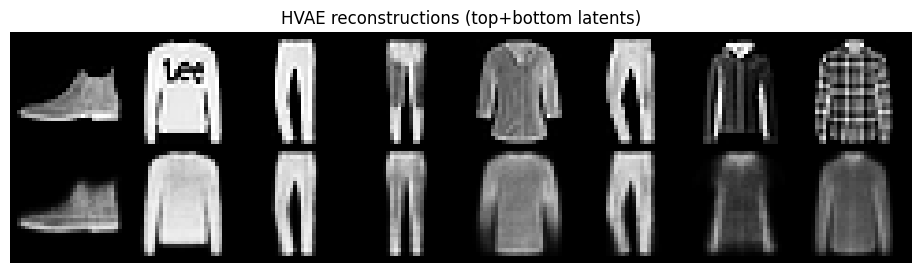

In [ ]:
plot_reconstructions(
    model=hvae,
    data_loader=test_loader,
    num_images=8,
    title="HVAE reconstructions (top+bottom latents)",
)


## 2.2 Inspecting the top latent space

Here we look only at the **top latent** $z^{(2)}$ (2D) and color the points by class.

Compare this to:

- the single latent 2D VAE from Part 1,
- or a 2D latent in a non-hierarchical VAE.

Questions to think about:

- Do the classes cluster more clearly in $z^{(2)}$?
- Does $z^{(2)}$ capture higher-level structure than $z^{(1)}$?


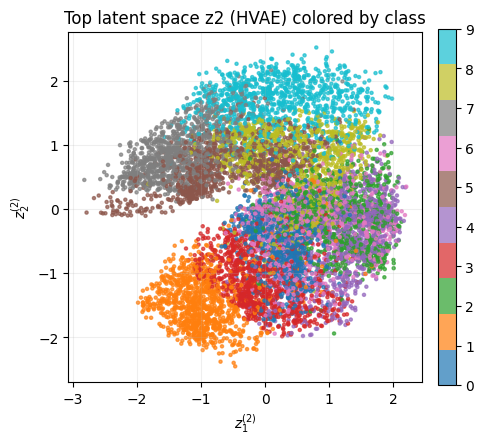

In [ ]:
@torch.no_grad()
def plot_top_latent_space(
    model: HierarchicalVAE,
    data_loader: DataLoader,
    max_batches: int = 100,
):
    if model.latent_dim_top != 2:
        print("Top latent dim is not 2; cannot make a 2D scatter.")
        return

    model.eval()

    all_mu2 = []
    all_labels = []

    for batch_idx, (x, y) in enumerate(data_loader):
        x = x.to(device)
        y = y.to(device)

        mu2_q, logvar2_q = model.encode_top(x)
        all_mu2.append(mu2_q)
        all_labels.append(y)

        if batch_idx + 1 >= max_batches:
            break

    mu2_all = torch.cat(all_mu2, dim=0).cpu()
    labels_all = torch.cat(all_labels, dim=0).cpu()

    plt.figure(figsize=(5, 5))
    scatter = plt.scatter(
        mu2_all[:, 0],
        mu2_all[:, 1],
        c=labels_all.numpy(),
        s=5,
        alpha=0.7,
        cmap="tab10",
    )
    plt.xlabel(r"$z^{(2)}_1$")
    plt.ylabel(r"$z^{(2)}_2$")
    plt.title("Top latent space z2 (HVAE) colored by class")
    plt.grid(alpha=0.2)
    plt.gca().set_aspect("equal", "box")
    plt.colorbar(scatter, fraction=0.046, pad=0.04)
    plt.show()

# Example:
plot_top_latent_space(hvae, test_loader)


## 2.3 Reflection and connection to deeper models

You have now implemented:

- a **single latent** VAE (Part 1),
- a **two-level hierarchical** VAE (Part 2).

In more advanced models such as **NVAE**:

- the architecture is convolutional and deep,
- there are *many* latent levels (e.g. per resolution scale),
- priors can be more expressive (e.g. using normalizing flows or autoregressive components),
- but the core ideas you used are still there:
  - latent hierarchy $z^{(L)}, \dots, z^{(1)}$,
  - conditional priors $p(z^{(\ell)} \mid z^{(\ell+1)})$,
  - ELBO with one reconstruction term and multiple KL terms.

When you move to **diffusion models**, you again see:

- a simple noise distribution (Gaussian),
- a learned transformation that maps noise to data,
- objectives related to likelihood and uncertainty.

**Questions to think about:**

1. Compare the 2D latent space of:
   - (a) the single latent VAE from Part 1 with `LATENT_DIM = 2`, and
   - (b) the top latent $z^{(2)}$ in this hierarchical VAE.
   Which one seems more “semantic” or class-clustered?

2. In your hierarchical VAE runs, do you see:
   - non-zero KL at the top level (z2),
   - non-zero KL at the bottom level (z1)?
   If one KL is almost zero, what does that say about how information is being used?

3. If you had a *third* latent level $z^{(3)}$, where would you expect the most
   abstract information to sit? What kinds of diagnostics from this notebook
   would you reuse to verify that?
